# Cyber Bullying

In [1]:
from typing import List
import nltk
import os
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from enchant.checker import SpellChecker
# from nltk.stem import WordNetLemmatizer
import swifter
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Preprocess

In [2]:

def merge_datasets(data_path='./Data/Source1') -> pd.DataFrame:
    df = pd.DataFrame()
    for filename in os.listdir(data_path):
        df1 = pd.read_csv(f'{data_path}/{filename}')
        df1 = df1[['Text', 'oh_label']]
        df = pd.concat([df, df1], axis=0)
    df["Text"] = df["Text"].astype(str)
    df = df.reset_index(drop=True)
    print("database merged successfully!")
    return df


def add_punctuation_stopwords_curse_features(df: pd.DataFrame) -> pd.DataFrame:
    def get_curses():
        lst = []
        with open("english_curse.csv") as curses_file:
            for curse in curses_file.readlines():
                lst.append(curse.replace("\n", ""))
        return lst

    curses = get_curses()
    features = list(string.punctuation) + list(stopwords.words('english')) + curses
    # new_features_cols = []
    for ch in features:
        df[ch] = df['Text'].astype(str).apply(lambda s: s.count(ch) / len(s))
    print("add_punctuation_and_stopwords_features successfully!")
    return df


def add_count_misspell_feature(df: pd.DataFrame) -> pd.DataFrame:
    def helper(data: str) -> float:
        spell = SpellChecker("en_US", data)
        counter = 0
        for _ in spell:
            counter += 1
        return counter / len(data)

    misspell_count = df["Text"].swifter.apply(helper).rename("misspell_count")
    df = pd.concat([df, misspell_count], axis=1)
    print("add_count_misspell_feature successfully!")
    return df


def add_avg_word_len_feature(df: pd.DataFrame) -> pd.DataFrame:
    avg_word_len = df["Text"].astype(str).swifter.apply(
        lambda s: pd.Series(nltk.word_tokenize(s)).map(len).mean()).rename("avg_word_len")
    df = pd.concat([df, avg_word_len], axis=1)
    print("add_avg_word_len_feature successfully!")
    return df


def add_avg_sentence_len_feature(df: pd.DataFrame) -> pd.DataFrame:
    sentence_count = df["Text"].astype(str).swifter.apply(
        lambda text: pd.Series(nltk.sent_tokenize(text)).map(lambda sent: len(nltk.word_tokenize(sent))).mean()) \
        .rename("sentence_count")

    df = pd.concat([df, sentence_count], axis=1)
    print("add_avg_sentence_len_feature successfully!")
    return df


def add_uppercase_count_feature(df: pd.DataFrame) -> pd.DataFrame:
    uppercase_count = df['Text'].str.findall(r'[A-Z]').str.len().rename("uppercase_count") / df["Text"].str.len()
    df = pd.concat([df, uppercase_count], axis=1)
    print("add_uppercase_count_feature successfully!")
    return df


def add_pos_features(df: pd.DataFrame) -> pd.DataFrame:
    def group_pos(tag):
        groups = {"noun": ['NN', 'NNS', 'NNP', 'NNPS'], "verb": ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
                  "adverb": ['RB', 'RBR', 'RBS'], "adjective": ['JJ', 'JJR', 'JJS']}
        for key, group in groups.items():
            if tag in group:
                return key
        return None

    features = df["Text"].swifter.apply(lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
                                        apply(group_pos).value_counts(normalize=True).copy())
    print("add_pos_features successfully!")
    features = features.fillna(0)
    return pd.concat([df, features], axis=1)


def to_one_hot_rep(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    cv = CountVectorizer()
    data_cv = cv.fit_transform(df[col_name])
    data_cv = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_cv["oh_label"] = df["oh_label"]
    return data_cv


def bug_fix(df: pd.DataFrame, ignored_columns: List[str]) -> pd.DataFrame:
    print("loaded!")
    df["uppercase_count"] /= df["Text"].str.len()
    print("fix broken col")
    X_df = df.drop(ignored_columns, axis=1)
    normalized_X_df = (X_df - X_df.mean()) / X_df.std()
    df = pd.concat([df[ignored_columns], normalized_X_df], axis=1)
    print("normalized")
    return df


def preprocess(train_part=0.7, use_cache=True, debug=True,data_path="./Data") -> (
        np.ndarray, np.ndarray, np.ndarray, np.ndarray, pd.DataFrame):
    print("preprocess...")
    cleaned_output_path = f"{data_path}/cleaned-debug.csv" if debug else f"{data_path}/cleaned.csv"
    label_name = "oh_label"
    ignored_columns = ["Text", label_name]
    if use_cache and os.path.isfile(cleaned_output_path):
        df = pd.read_csv(cleaned_output_path, index_col=0)
        # df = bug_fix(df,label_name)
    else:
        df = merge_datasets()
        df = add_pos_features(df)
        df = add_punctuation_stopwords_curse_features(df)
        df = add_uppercase_count_feature(df)
        df = add_avg_word_len_feature(df)
        df = add_count_misspell_feature(df)
        df = add_avg_sentence_len_feature(df)
        # df["Text"] = df["Text"].apply(process_row)
        # df = to_one_hot_rep(df)
        if not debug:
            df.to_csv(cleaned_output_path)
        print("Saved")
    df = df.fillna(0)
    x = df.drop(ignored_columns, axis=1).values
    y = df[label_name].values
    num_rows = x.shape[0]
    mask_train = np.zeros(num_rows, dtype=bool)
    mask_train[np.random.choice(num_rows, int(num_rows * train_part), replace=False)] = True
    print(mask_train.shape, x.shape, y.shape)
    return x[mask_train, :], y[mask_train], x[~mask_train, :], y[~mask_train], df


## Model Implementation
using tensorflow version 1

In [3]:
import tensorflow.compat.v1 as tf
import numpy as np
from typing import List

tf.disable_v2_behavior()
eps = 1e-2


def save_loss(data: list, filename: str):
    with open(filename, 'w') as f:
        for item in data:
            f.write("%s\n" % item)


class LogisticRegression:
    def __init__(self, X_train: np.ndarray, y_train: np.ndarray, epoch=30, learning_rate=0.001, batch_size=100):
        """
        weighted logistic regression using cross entropy loss function
        :param num_iter:
        :param batch_size: -1 means all
        """
        self.losses = []
        self.sess = tf.Session()
        features = X_train.shape[1]
        self.x = tf.placeholder(tf.float64, [None, features])
        y_train_variable = tf.placeholder(tf.float64, [None, 1])
        W = tf.Variable(tf.zeros([features, 1],dtype=tf.float64))
        b = tf.Variable(tf.zeros([1],dtype=tf.float64))
        self.y = 1 / (1.0 + tf.exp(-(tf.matmul(self.x, W) + b)))
        w1_weight = (y_train == 1).sum()    # for imbalance data
        w0_weight = (y_train == 0).sum()
        loss = tf.reduce_mean(-(((w1_weight+w0_weight)/w1_weight) * y_train_variable * tf.log(self.y + eps) + ((w1_weight+w0_weight)/w0_weight) * (1 - y_train_variable) * tf.log(
            1 - self.y + eps)))  # cross entropy
        update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  # TODO: check other optimizers
        self.sess.run(tf.global_variables_initializer())
        np.random.shuffle(X_train)
        rows_num = X_train.shape[0]
        for i in range(0, epoch * (rows_num//batch_size)):
            counter_step = i % (rows_num // batch_size)
            X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = Y_batch.reshape((Y_batch.size, 1))
            self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            if i % (rows_num//batch_size) == 0:
                print(f"iteration {i}: loss value is: {loss_value}")
                self.losses.append(loss_value)
        save_loss(self.losses, filename="LogisticRegression.txt")

    def predict(self, X_test, thr=0.5):
        predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions


class MLP:
    """
    multi level perceptron implementation using tensorflow version 1
    """

    def __init__(self, X_train: np.ndarray, y_train, layers_sizes: List[int], learning_rate=0.0001, epoch=50, batch_size=100):
        """
        Feed Foreword Neural network using Batch gradient decent optimizer
        :param layers_sizes: len of this list need to be greater than 1
        :param num_iter:
        :param print_step: print loss value every print_step echos
        """
        self.sess = tf.Session()
        self.losses = []
        rows_num, features = X_train.shape[0], X_train.shape[1]
        self.x = tf.placeholder(tf.float64, [None, features])
        y_train_variable = tf.placeholder(tf.float64, [None, 1])
        layers_sizes = [features] + layers_sizes.copy() + [1]
        W, b = [], []
        for i, layer_size in enumerate(layers_sizes[1:]):
            W.append(tf.Variable(tf.zeros([layers_sizes[i], layer_size],dtype=tf.float64)))
            b.append(tf.Variable(tf.zeros([layer_size],dtype=tf.float64)))
        # ff
        prev_output = tf.nn.relu(tf.matmul(self.x, W[0]) + b[0])
        for layer_w, layer_b in zip(W[1:-1], b[1:-1]):
            print(prev_output)
            prev_output = tf.nn.relu(1 / (1.0 + tf.exp(-(tf.add(tf.matmul(prev_output, layer_w), layer_b)))))
        print(prev_output)
        self.y = tf.nn.sigmoid(1 / (1.0 + tf.exp(-(tf.add(tf.matmul(prev_output, W[-1]), b[-1])))))
        print(self.y)
        w1_weight = (y_train == 1).sum()  # for imbalance data
        w0_weight = (y_train == 0).sum()
        # cross entropy
        loss = tf.reduce_mean(-(((w1_weight+w0_weight)/w1_weight)*y_train_variable * tf.log(self.y + eps) +
                                ((w1_weight+w0_weight)/w0_weight)*(1 - y_train_variable) * tf.log(1 - self.y + eps)))
        update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  # TODO: check other optimizers
        self.sess.run(tf.global_variables_initializer())
        np.random.shuffle(X_train)
        for i in range(0, epoch * (rows_num//batch_size)):
            # print(self.sess.run(W))
            counter_step = i % (rows_num // batch_size)
            X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = Y_batch.reshape((Y_batch.size, 1))
            # print("before:",self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch}))
            self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            if i % (rows_num//batch_size) == 0:
                print(f"iteration {i}: loss value is: {loss_value}")
                self.losses.append(loss_value)
        save_loss(self.losses, filename="MLP.txt")

    def predict(self, X_test, thr=0.5):
        predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions



## Exploration

In [4]:
x_train, y_train, x_test, y_test, df = preprocess(use_cache=True, debug=False,data_path="../Data/")
df.head()

preprocess...
(448880,) (448880, 595) (448880,)


,Text,oh_label,adjective,adverb,noun,verb,!,"""",#,$,...,xx,xxx,yaoi,yellow showers,yiffy,zoophilia,ðŸ–•,uppercase_count,avg_word_len,misspell_count
0,`- This is not ``creative``. Those are the di...,0.0,0.704151,0.130975,-0.511120,0.113224,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.097900,0.000670,-0.534211
1,` :: the term ``standard model`` is itself le...,0.0,0.611175,0.069942,-0.154997,-0.234684,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.113050,-0.041753,-0.579315
2,"True or false, the situation as of March 200...",0.0,0.431937,-1.116819,0.881958,-0.694260,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.080581,0.001535,-0.471277
3,"Next, maybe you could work on being less cond...",0.0,-0.516089,1.165731,-1.184439,1.098284,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.125048,0.040398,-0.364195
4,This page will need disambiguation.,0.0,-1.334839,-1.116819,1.081539,0.176231,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.436211,0.252417,-0.671879


In [6]:
weights = df['oh_label'].copy()
weights[weights == 1] = 4
weights[weights == 0] = 1

In [11]:
df = df[['Text','oh_label']]
df = df.sample(50000,weights=weights)

In [17]:
df = pd.read_csv("temp.csv",index_col=0)

In [7]:
print(sum([True for idx,row in df.iterrows() if any(row.isnull())]))
nan_col = df.isna().sum()
ls = len([i for i, j in nan_col.items() if j > 0])
print(ls)

0
0


In [6]:
df = df.reset_index()

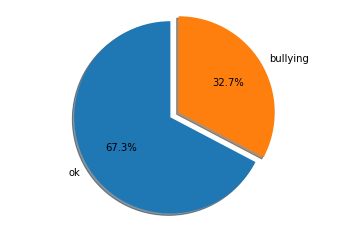

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


fig1, ax1 = plt.subplots()
ax1.pie(df["oh_label"].value_counts(), explode=(0, 0.1), labels=["ok","bullying"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<AxesSubplot:>

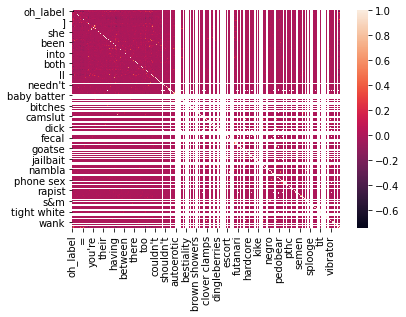

In [19]:
sns.heatmap(df.corr())

In [24]:
import string
printable = set(string.printable)#ascii chars
df['Text'] = df['Text'].swifter.apply(lambda s : ''.join(filter(lambda x: x in printable, s)))

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [32]:
import re
regex = re.compile('[0-9]')
df['Text'] = df['Text'].swifter.apply(lambda s : regex.sub("",s))

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
from spellchecker import SpellChecker

spell  = SpellChecker()
def spell_check(x):
    correct_word = []
    mispelled_word = x.split()
    for word in mispelled_word:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)

df['Text'] = df['Text'].swifter.apply(lambda s : spell_check(str(s)))

In [30]:
count_vect = CountVectorizer()#max_features=1000
X_train_counts = count_vect.fit_transform(df['Text'])
X_train_counts

<50000x94977 sparse matrix of type '<class 'numpy.int64'>'
	with 1856338 stored elements in Compressed Sparse Row format>

In [23]:
count_vect_df = pd.DataFrame(X_train_counts.toarray(), columns=count_vect.get_feature_names())
count_vect_df

,able,about,above,absolutely,abuse,accept,accepted,access,according,account,...,yes,yet,you,youbollocks,youll,your,youre,yourself,yourselfgo,youve
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,2,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,2,2,3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
49996,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
count_vect_df[count_vect_df.columns.drop(list(count_vect_df.filter(regex='[0-9]')))]

MemoryError: Unable to allocate 30.3 GiB for an array with shape (50000, 81453) and data type int64

In [35]:
df = pd.concat([df,count_vect_df],axis=1)

MemoryError: Unable to allocate 33.0 GiB for an array with shape (88520, 50000) and data type int64

In [17]:
X,y = df.drop(['index',"Text","oh_label"],axis=1),df['oh_label']
X.shape,y.shape

((50000, 500), (50000,))

In [18]:
X

,about,above,account,actually,add,added,adding,address,admin,administrator,...,wrong,www,year,years,yes,yet,you,your,yourself,yourselfgo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,2,3,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

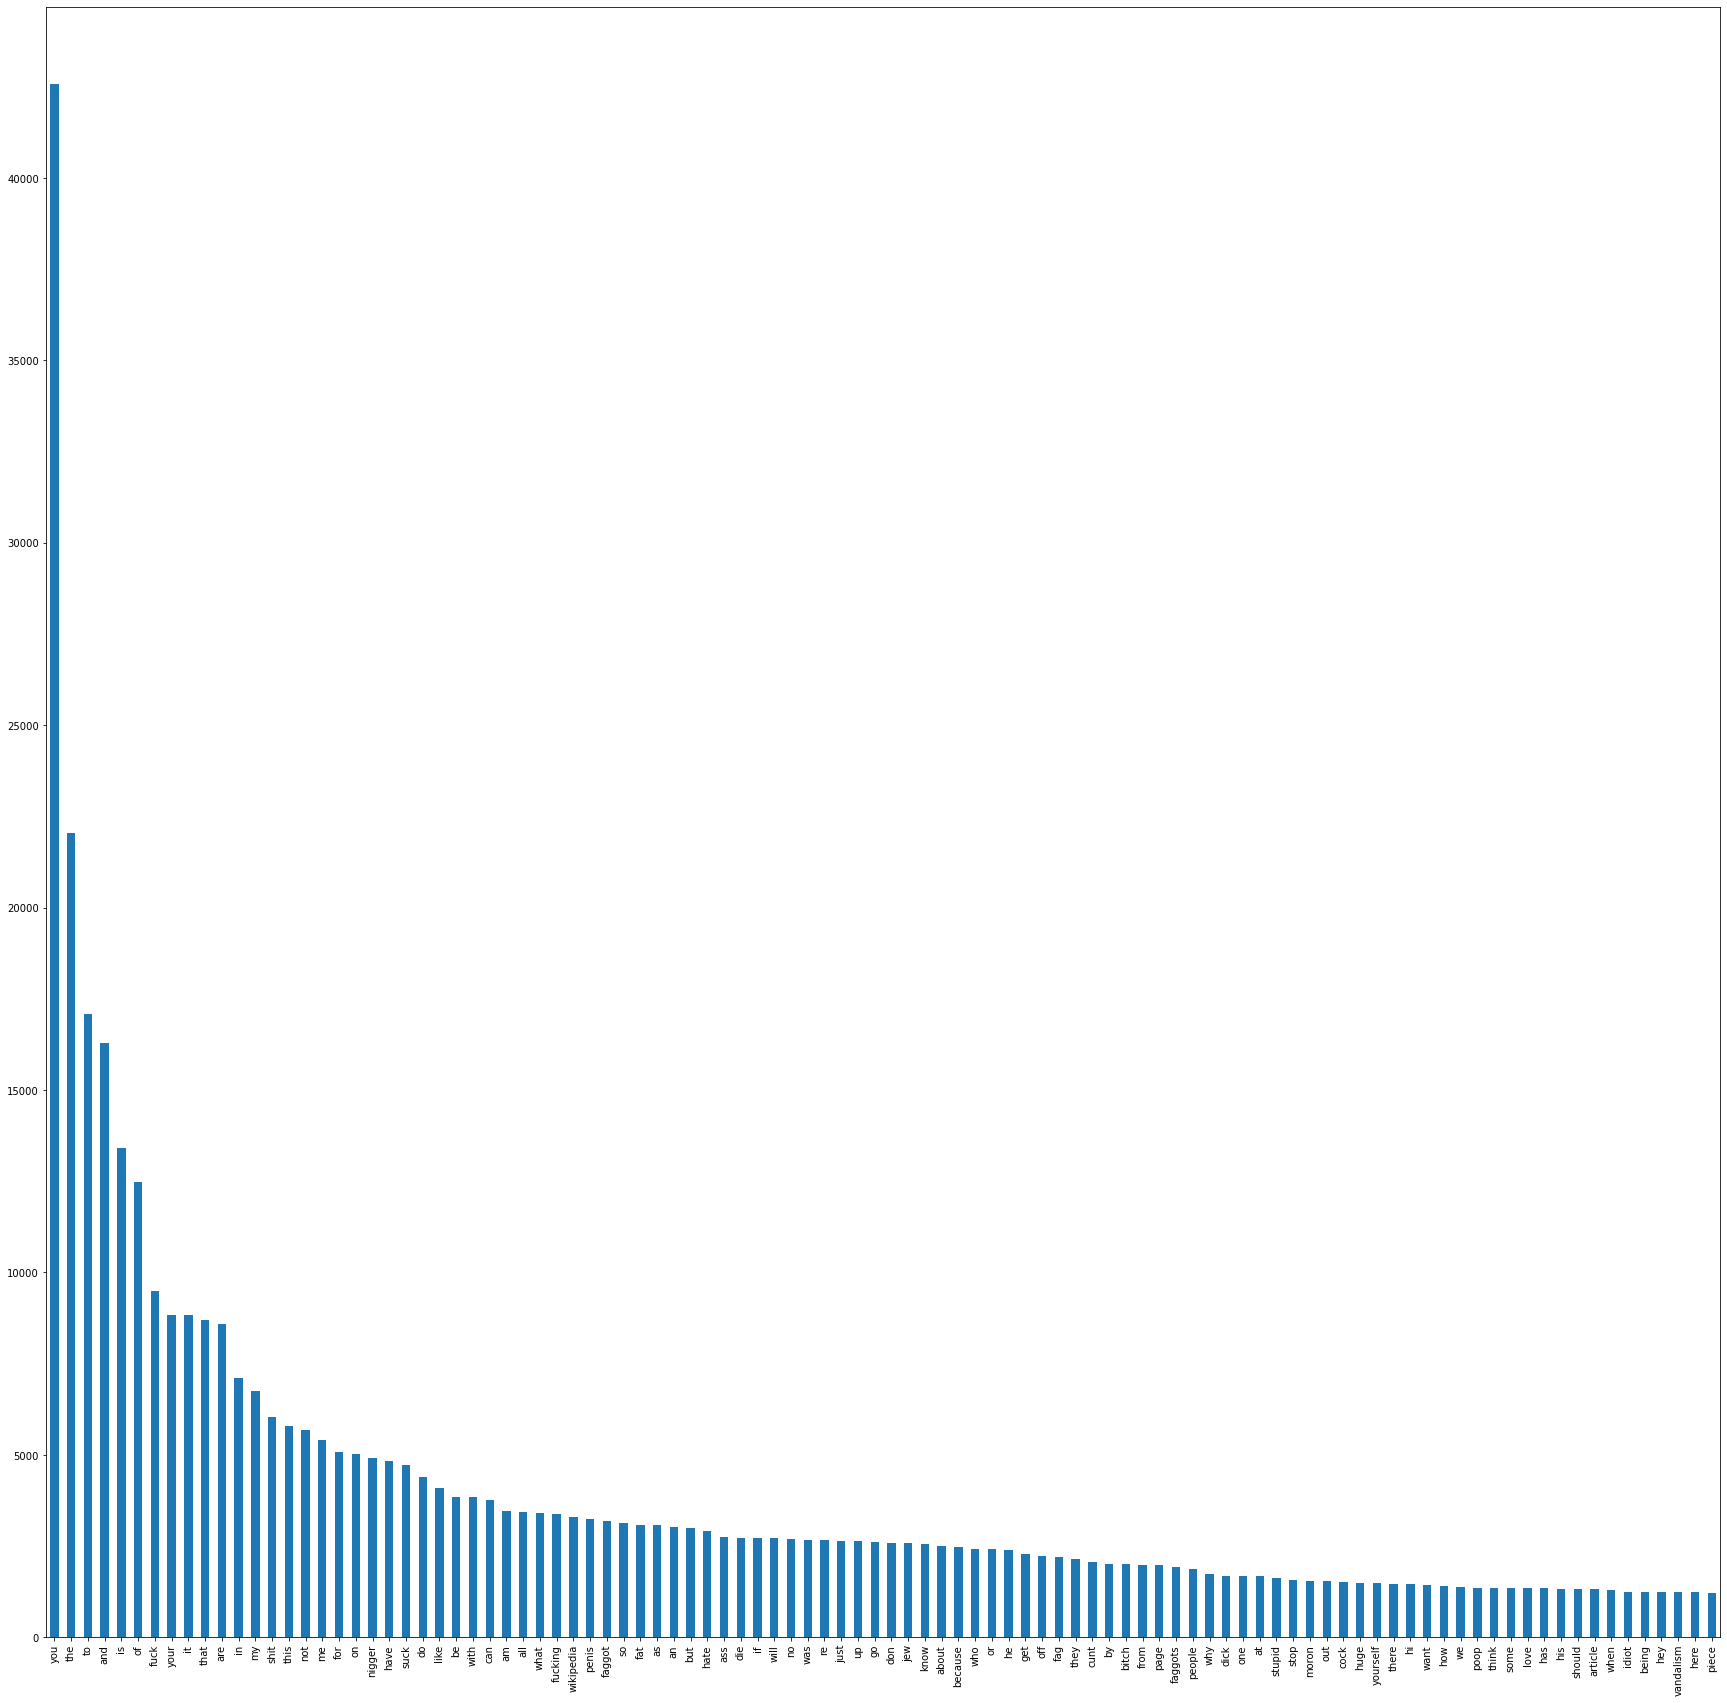

In [30]:
plt.figure(figsize=(30, 30))
X[y == 1].sum().sort_values(ascending=False)[:100].plot(kind='bar')

<AxesSubplot:>

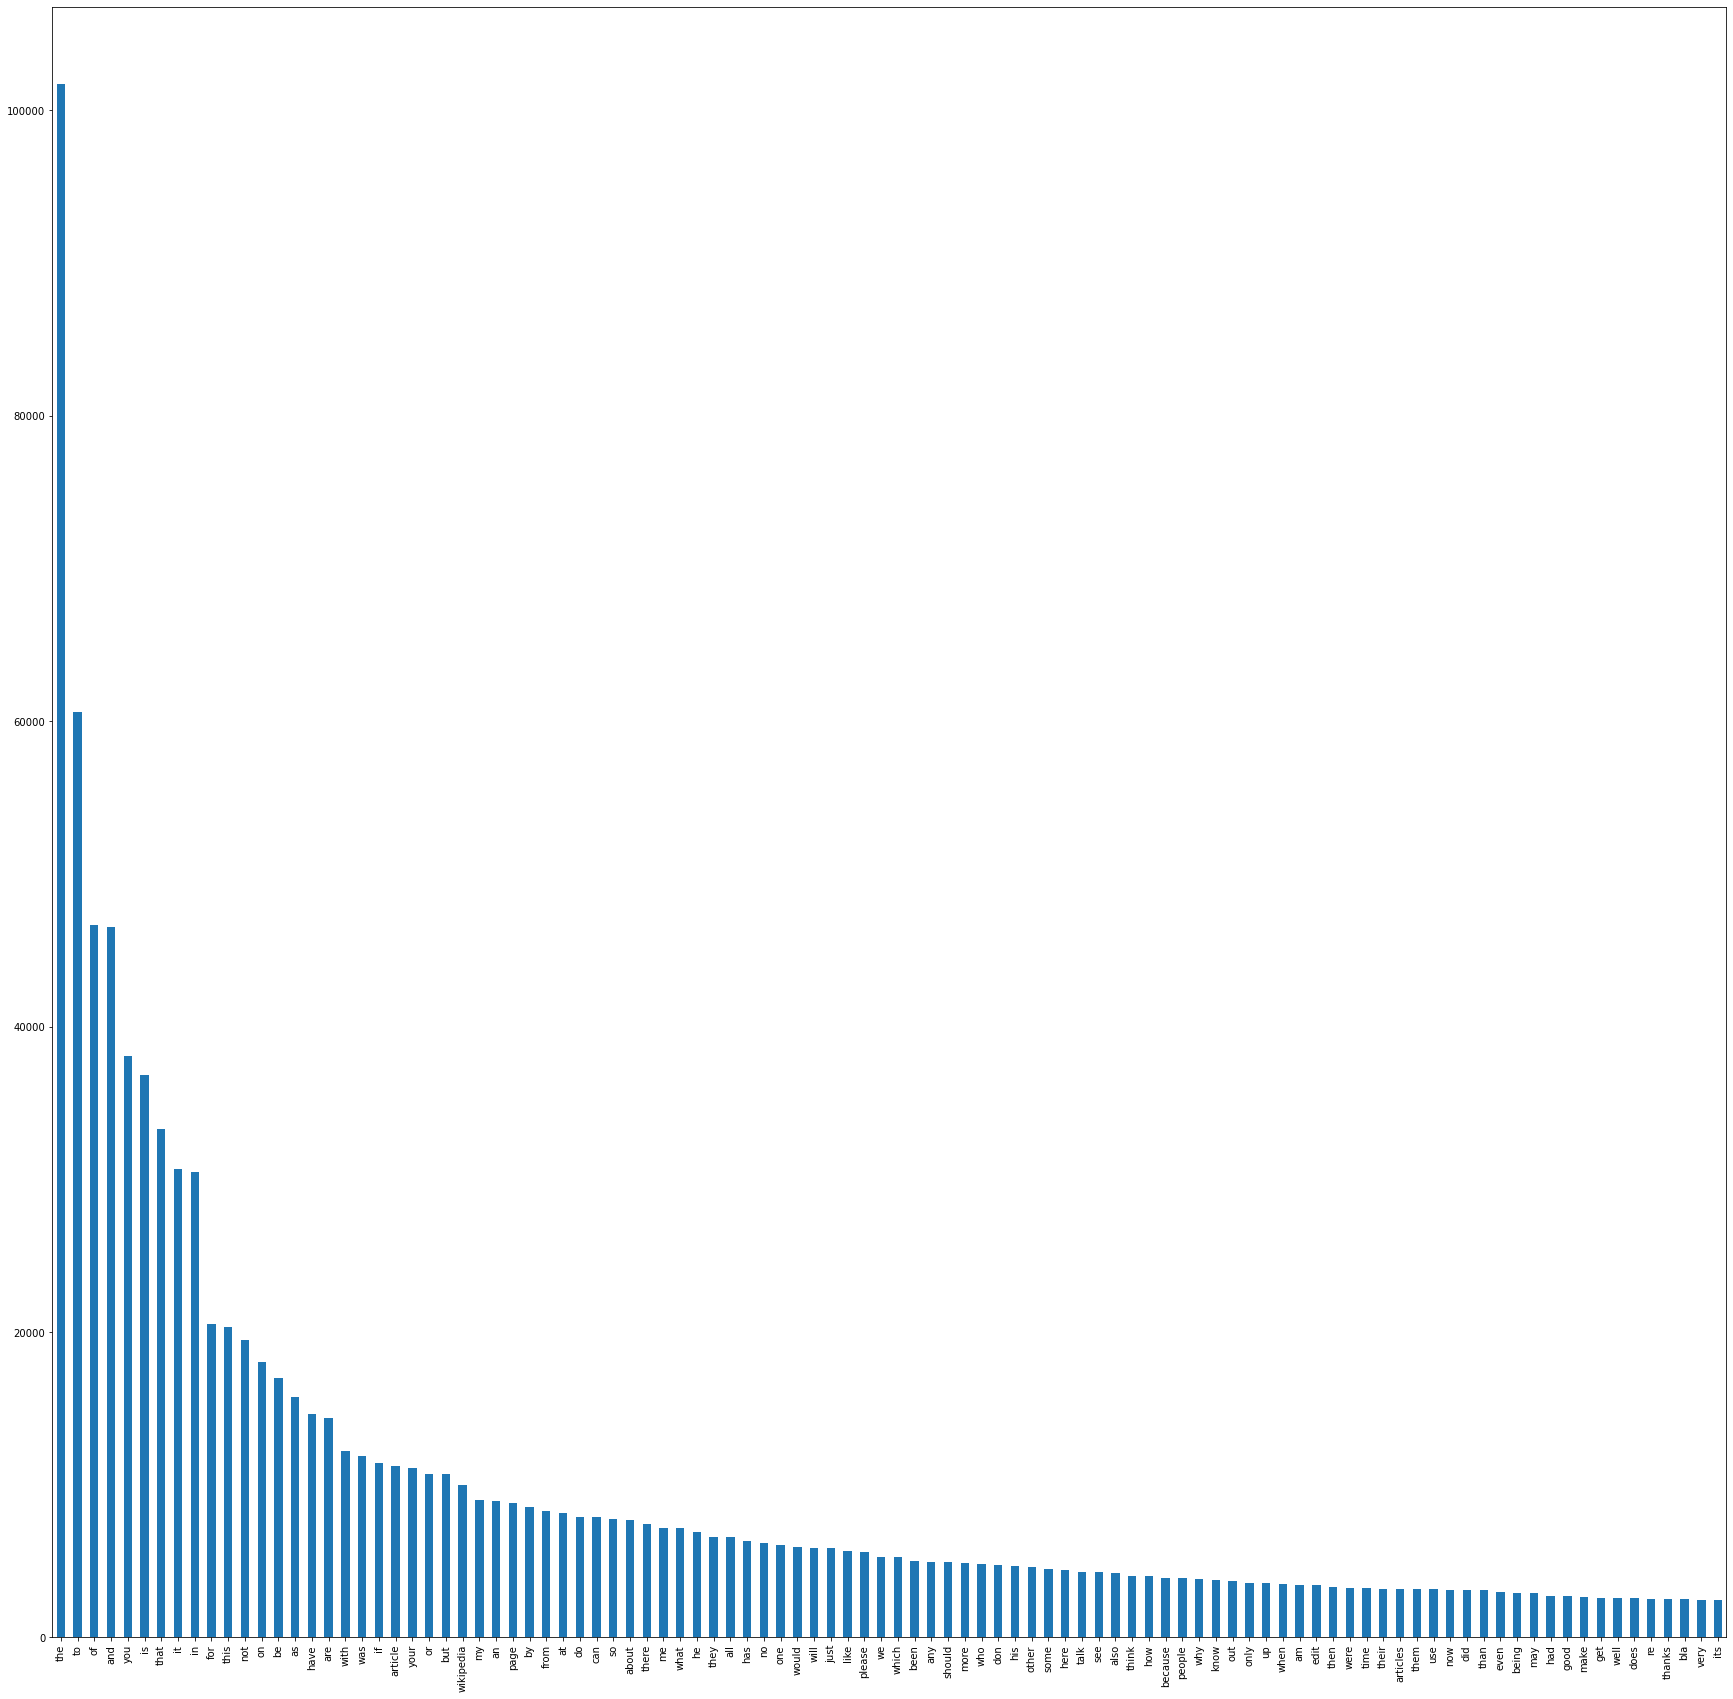

In [31]:
plt.figure(figsize=(30, 30))
X[y == 0].sum().sort_values(ascending=False)[:100].plot(kind='bar')

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## Models

In [16]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [17]:
label_0_weight = y.size / (y == 0).sum()
label_1_weight = y.size / (y == 1).sum()
label_1_weight,label_0_weight

(7.753140021708792, 1.1480792633923447)

In [18]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=10000,class_weight={0:label_0_weight,1:label_1_weight})
logmodel.fit(x_train,y_train)
predictions = logmodel.predict(x_test)
print(classification_report(y_test,predictions,zero_division=0))

              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88      8687
         1.0       0.38      0.75      0.51      1313

    accuracy                           0.81     10000
   macro avg       0.67      0.78      0.69     10000
weighted avg       0.88      0.81      0.83     10000



In [21]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=10000,hidden_layer_sizes=(500,200,100),activation='relu')
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(classification_report(y_test,preds,zero_division=0))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      8687
         1.0       0.63      0.51      0.56      1313

    accuracy                           0.90     10000
   macro avg       0.78      0.73      0.75     10000
weighted avg       0.89      0.90      0.89     10000



In [17]:
logistic = LogisticRegression(x_train.values,y_train.values,epoch=10000)
predictions = logistic.predict(x_test.values)
print(classification_report(y_test.values, predictions,zero_division=0))

iteration 0: loss value is: 1.1675309016176094
iteration 2693: loss value is: 1.1719051023085263
iteration 5386: loss value is: 1.1729329904576808
iteration 8079: loss value is: 1.173021075600552
iteration 10772: loss value is: 1.1730278605287445
iteration 13465: loss value is: 1.1730534450001449
iteration 16158: loss value is: 1.173108091522783
iteration 18851: loss value is: 1.1731743728768782
iteration 21544: loss value is: 1.173247393428125
iteration 24237: loss value is: 1.173321678809083
iteration 26930: loss value is: 1.173385630844561
iteration 29623: loss value is: 1.173445269931723
iteration 32316: loss value is: 1.1735075301972324
iteration 35009: loss value is: 1.17355892068326
iteration 37702: loss value is: 1.1736133090969019
iteration 40395: loss value is: 1.1736534408210149
iteration 43088: loss value is: 1.1737039698242602
iteration 45781: loss value is: 1.1737351407176362
iteration 48474: loss value is: 1.1737821059948146
iteration 51167: loss value is: 1.173808261150

iteration 430880: loss value is: 1.1745470593361313
iteration 433573: loss value is: 1.1745383402756338
iteration 436266: loss value is: 1.174548150023801
iteration 438959: loss value is: 1.1745394228352717
iteration 441652: loss value is: 1.1745492248390492
iteration 444345: loss value is: 1.1745404898223513
iteration 447038: loss value is: 1.174550284366395
iteration 449731: loss value is: 1.1745415417983538
iteration 452424: loss value is: 1.1745513291454863
iteration 455117: loss value is: 1.1745425792820037
iteration 457810: loss value is: 1.1745523596752188
iteration 460503: loss value is: 1.1745436027531873
iteration 463196: loss value is: 1.1745533764174612
iteration 465889: loss value is: 1.1745446126564978
iteration 468582: loss value is: 1.174554379800432
iteration 471275: loss value is: 1.1745456094044495
iteration 473968: loss value is: 1.1745553702217604
iteration 476661: loss value is: 1.1745465933803885
iteration 479354: loss value is: 1.1745563480512535
iteration 48204

iteration 859067: loss value is: 1.174594748069201
iteration 861760: loss value is: 1.1746042498707054
iteration 864453: loss value is: 1.1745952057237672
iteration 867146: loss value is: 1.1746047052972777
iteration 869839: loss value is: 1.1745956588401076
iteration 872532: loss value is: 1.1746051562098525
iteration 875225: loss value is: 1.1745961074675066
iteration 877918: loss value is: 1.1746056026574325
iteration 880611: loss value is: 1.1745965516546741
iteration 883304: loss value is: 1.1746060446884494
iteration 885997: loss value is: 1.1745969914497547
iteration 888690: loss value is: 1.1746064823507723
iteration 891383: loss value is: 1.1745974269003348
iteration 894076: loss value is: 1.174606915691716
iteration 896769: loss value is: 1.1745978580534495
iteration 899462: loss value is: 1.17460734475805
iteration 902155: loss value is: 1.1745982849555927
iteration 904848: loss value is: 1.1746077695960029
iteration 907541: loss value is: 1.174598707652721
iteration 910234:

iteration 1281868: loss value is: 1.1746292662939204
iteration 1284561: loss value is: 1.1746200994754505
iteration 1287254: loss value is: 1.1746294821164873
iteration 1289947: loss value is: 1.1746203142915694
iteration 1292640: loss value is: 1.1746296959742215
iteration 1295333: loss value is: 1.1746205271532935
iteration 1298026: loss value is: 1.1746299078875224
iteration 1300719: loss value is: 1.1746207380809086
iteration 1303412: loss value is: 1.1746301178765675
iteration 1306105: loss value is: 1.1746209470944793
iteration 1308798: loss value is: 1.174630325961313
iteration 1311491: loss value is: 1.1746211542138507
iteration 1314184: loss value is: 1.1746305321614987
iteration 1316877: loss value is: 1.1746213594586539
iteration 1319570: loss value is: 1.1746307364966504
iteration 1322263: loss value is: 1.1746215628483052
iteration 1324956: loss value is: 1.1746309389860803
iteration 1327649: loss value is: 1.1746217644020103
iteration 1330342: loss value is: 1.17463113964

iteration 1701976: loss value is: 1.1746414816082533
iteration 1704669: loss value is: 1.174632260553188
iteration 1707362: loss value is: 1.174641591589256
iteration 1710055: loss value is: 1.1746323700806836
iteration 1712748: loss value is: 1.1746417006857355
iteration 1715441: loss value is: 1.1746324787281726
iteration 1718134: loss value is: 1.174641808906513
iteration 1720827: loss value is: 1.1746325865044296
iteration 1723520: loss value is: 1.174641916260318
iteration 1726213: loss value is: 1.1746326934181368
iteration 1728906: loss value is: 1.174642022755788
iteration 1731599: loss value is: 1.174632799477886
iteration 1734292: loss value is: 1.17464212840147
iteration 1736985: loss value is: 1.1746329046921777
iteration 1739678: loss value is: 1.1746422332058213
iteration 1742371: loss value is: 1.1746330090694237
iteration 1745064: loss value is: 1.1746423371772101
iteration 1747757: loss value is: 1.174633112617948
iteration 1750450: loss value is: 1.174642440323918
ite

iteration 2122084: loss value is: 1.1746479615506622
iteration 2124777: loss value is: 1.1746387157089517
iteration 2127470: loss value is: 1.1746480232103407
iteration 2130163: loss value is: 1.1746387771572748
iteration 2132856: loss value is: 1.174648084458259
iteration 2135549: loss value is: 1.1746388381958446
iteration 2138242: loss value is: 1.1746481452983337
iteration 2140935: loss value is: 1.174638898828557
iteration 2143628: loss value is: 1.174648205734441
iteration 2146321: loss value is: 1.1746389590592679
iteration 2149014: loss value is: 1.1746482657704171
iteration 2151707: loss value is: 1.1746390188917935
iteration 2154400: loss value is: 1.1746483254100597
iteration 2157093: loss value is: 1.1746390783299117
iteration 2159786: loss value is: 1.1746483846571267
iteration 2162479: loss value is: 1.1746391373773613
iteration 2165172: loss value is: 1.1746484435153395
iteration 2167865: loss value is: 1.1746391960378426
iteration 2170558: loss value is: 1.1746485019883

iteration 2542192: loss value is: 1.174651783168108
iteration 2544885: loss value is: 1.1746425255723645
iteration 2547578: loss value is: 1.1746518219421684
iteration 2550271: loss value is: 1.1746425642436185
iteration 2552964: loss value is: 1.1746518605162233
iteration 2555657: loss value is: 1.174642602715777
iteration 2558350: loss value is: 1.1746518988920471
iteration 2561043: loss value is: 1.1746426409906054
iteration 2563736: loss value is: 1.1746519370713964
iteration 2566429: loss value is: 1.1746426790698516
iteration 2569122: loss value is: 1.1746519750560105
iteration 2571815: loss value is: 1.1746427169552458
iteration 2574508: loss value is: 1.1746520128476114
iteration 2577201: loss value is: 1.174642754648501
iteration 2579894: loss value is: 1.1746520504479039
iteration 2582587: loss value is: 1.1746427921513136
iteration 2585280: loss value is: 1.1746520878585753
iteration 2587973: loss value is: 1.1746428294653624
iteration 2590666: loss value is: 1.1746521250812

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(classification_report(y_test,predictions,zero_division=0))

In [ ]:
mlp = MLP(x_train.values, y_train.values, [500,350,200,100],epoch=5000)
mlp_predictions = mlp.predict(x_test.values)
print(classification_report(y_test.values, mlp_predictions, zero_division=0))

Tensor("Relu:0", shape=(?, 500), dtype=float64)
Tensor("Relu_1:0", shape=(?, 350), dtype=float64)
Tensor("Relu_2:0", shape=(?, 200), dtype=float64)
Tensor("Relu_3:0", shape=(?, 100), dtype=float64)
Tensor("Sigmoid:0", shape=(?, 1), dtype=float64)
iteration 0: loss value is: 1.3104356197346794
iteration 2693: loss value is: 1.277981425343239
iteration 5386: loss value is: 1.2560030882949145
iteration 8079: loss value is: 1.2412403779147787
iteration 10772: loss value is: 1.2310077887993833
iteration 13465: loss value is: 1.2236235155682615
iteration 16158: loss value is: 1.2180883525031598
iteration 18851: loss value is: 1.2138007958441133
iteration 21544: loss value is: 1.2103866807599706
iteration 24237: loss value is: 1.2076045642924702
iteration 26930: loss value is: 1.205293078522046
iteration 29623: loss value is: 1.2033408798782383
iteration 32316: loss value is: 1.2016689317660172
iteration 35009: loss value is: 1.200219707483226
iteration 37702: loss value is: 1.198950400322765

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(["Text","oh_label"],axis=1), df["oh_label"], test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [9]:
import xgboost as xgb
param = {"learning_rate":0.05, "max_depth":8,"min_child_weight":1,"gamma":0,"subsample":0.7,
    "objective":'binary:logistic', "scale_pos_weight":1,"seed":93,"eval_metric":"logloss"}
# "colsample_bytree":0.8# evals=evals, early_stopping_rounds=10
dtrain = xgb.DMatrix(x_train.values, label=y_train.values)
deval = xgb.DMatrix(x_val.values, label=y_val.values)
evallist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 10000
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-logloss:0.65978	train-logloss:0.65965
[1]	eval-logloss:0.62949	train-logloss:0.62944
[2]	eval-logloss:0.60198	train-logloss:0.60194
[3]	eval-logloss:0.57683	train-logloss:0.57673
[4]	eval-logloss:0.55375	train-logloss:0.55360
[5]	eval-logloss:0.53267	train-logloss:0.53252
[6]	eval-logloss:0.51321	train-logloss:0.51302
[7]	eval-logloss:0.49530	train-logloss:0.49509
[8]	eval-logloss:0.47869	train-logloss:0.47838
[9]	eval-logloss:0.46336	train-logloss:0.46299
[10]	eval-logloss:0.44920	train-logloss:0.44872
[11]	eval-logloss:0.43604	train-logloss:0.43547
[12]	eval-logloss:0.42382	train-logloss:0.42318
[13]	eval-logloss:0.41242	train-logloss:0.41164
[14]	eval-logloss:0.40180	train-logloss:0.40097
[15]	eval-logloss:0.39194	train-logloss:0.39100
[16]	eval-logloss:0.38277	train-logloss:0.38167
[17]	eval-logloss:0.37420	train-logloss:0.37301
[18]	eval-logloss:0.36623	train-logloss:0.36499
[19]	eval-logloss:0.35885	train-logloss:0.35751
[20]	eval-logloss:0.35176	train-logloss:0.35032
[2

[170]	eval-logloss:0.21395	train-logloss:0.19446
[171]	eval-logloss:0.21377	train-logloss:0.19417
[172]	eval-logloss:0.21362	train-logloss:0.19384
[173]	eval-logloss:0.21351	train-logloss:0.19371
[174]	eval-logloss:0.21341	train-logloss:0.19356
[175]	eval-logloss:0.21329	train-logloss:0.19338
[176]	eval-logloss:0.21322	train-logloss:0.19329
[177]	eval-logloss:0.21308	train-logloss:0.19304
[178]	eval-logloss:0.21296	train-logloss:0.19289
[179]	eval-logloss:0.21282	train-logloss:0.19264
[180]	eval-logloss:0.21276	train-logloss:0.19256
[181]	eval-logloss:0.21268	train-logloss:0.19244
[182]	eval-logloss:0.21249	train-logloss:0.19215
[183]	eval-logloss:0.21240	train-logloss:0.19202
[184]	eval-logloss:0.21233	train-logloss:0.19191
[185]	eval-logloss:0.21220	train-logloss:0.19165
[186]	eval-logloss:0.21201	train-logloss:0.19140
[187]	eval-logloss:0.21185	train-logloss:0.19112
[188]	eval-logloss:0.21176	train-logloss:0.19101
[189]	eval-logloss:0.21169	train-logloss:0.19089
[190]	eval-logloss:0

[338]	eval-logloss:0.19950	train-logloss:0.17055
[339]	eval-logloss:0.19943	train-logloss:0.17042
[340]	eval-logloss:0.19936	train-logloss:0.17027
[341]	eval-logloss:0.19933	train-logloss:0.17019
[342]	eval-logloss:0.19924	train-logloss:0.17002
[343]	eval-logloss:0.19917	train-logloss:0.16991
[344]	eval-logloss:0.19913	train-logloss:0.16982
[345]	eval-logloss:0.19906	train-logloss:0.16972
[346]	eval-logloss:0.19900	train-logloss:0.16961
[347]	eval-logloss:0.19897	train-logloss:0.16956
[348]	eval-logloss:0.19881	train-logloss:0.16923
[349]	eval-logloss:0.19871	train-logloss:0.16904
[350]	eval-logloss:0.19865	train-logloss:0.16893
[351]	eval-logloss:0.19854	train-logloss:0.16874
[352]	eval-logloss:0.19852	train-logloss:0.16870
[353]	eval-logloss:0.19839	train-logloss:0.16847
[354]	eval-logloss:0.19836	train-logloss:0.16842
[355]	eval-logloss:0.19834	train-logloss:0.16838
[356]	eval-logloss:0.19831	train-logloss:0.16834
[357]	eval-logloss:0.19820	train-logloss:0.16809
[358]	eval-logloss:0

[506]	eval-logloss:0.19013	train-logloss:0.15320
[507]	eval-logloss:0.19009	train-logloss:0.15314
[508]	eval-logloss:0.19001	train-logloss:0.15298
[509]	eval-logloss:0.19000	train-logloss:0.15295
[510]	eval-logloss:0.18996	train-logloss:0.15288
[511]	eval-logloss:0.18991	train-logloss:0.15277
[512]	eval-logloss:0.18988	train-logloss:0.15269
[513]	eval-logloss:0.18984	train-logloss:0.15263
[514]	eval-logloss:0.18978	train-logloss:0.15253
[515]	eval-logloss:0.18966	train-logloss:0.15229
[516]	eval-logloss:0.18962	train-logloss:0.15220
[517]	eval-logloss:0.18956	train-logloss:0.15210
[518]	eval-logloss:0.18953	train-logloss:0.15202
[519]	eval-logloss:0.18947	train-logloss:0.15194
[520]	eval-logloss:0.18945	train-logloss:0.15190
[521]	eval-logloss:0.18943	train-logloss:0.15186
[522]	eval-logloss:0.18940	train-logloss:0.15183
[523]	eval-logloss:0.18936	train-logloss:0.15175
[524]	eval-logloss:0.18935	train-logloss:0.15174
[525]	eval-logloss:0.18932	train-logloss:0.15168
[526]	eval-logloss:0

[674]	eval-logloss:0.18226	train-logloss:0.13835
[675]	eval-logloss:0.18220	train-logloss:0.13826
[676]	eval-logloss:0.18218	train-logloss:0.13823
[677]	eval-logloss:0.18215	train-logloss:0.13814
[678]	eval-logloss:0.18211	train-logloss:0.13807
[679]	eval-logloss:0.18208	train-logloss:0.13805
[680]	eval-logloss:0.18205	train-logloss:0.13795
[681]	eval-logloss:0.18200	train-logloss:0.13783
[682]	eval-logloss:0.18199	train-logloss:0.13781
[683]	eval-logloss:0.18193	train-logloss:0.13772
[684]	eval-logloss:0.18186	train-logloss:0.13761
[685]	eval-logloss:0.18184	train-logloss:0.13755
[686]	eval-logloss:0.18180	train-logloss:0.13749
[687]	eval-logloss:0.18177	train-logloss:0.13744
[688]	eval-logloss:0.18175	train-logloss:0.13740
[689]	eval-logloss:0.18168	train-logloss:0.13727
[690]	eval-logloss:0.18163	train-logloss:0.13719
[691]	eval-logloss:0.18157	train-logloss:0.13707
[692]	eval-logloss:0.18156	train-logloss:0.13706
[693]	eval-logloss:0.18153	train-logloss:0.13700
[694]	eval-logloss:0

[842]	eval-logloss:0.17586	train-logloss:0.12604
[843]	eval-logloss:0.17584	train-logloss:0.12598
[844]	eval-logloss:0.17578	train-logloss:0.12586
[845]	eval-logloss:0.17577	train-logloss:0.12582
[846]	eval-logloss:0.17574	train-logloss:0.12579
[847]	eval-logloss:0.17574	train-logloss:0.12577
[848]	eval-logloss:0.17569	train-logloss:0.12569
[849]	eval-logloss:0.17566	train-logloss:0.12563
[850]	eval-logloss:0.17564	train-logloss:0.12557
[851]	eval-logloss:0.17560	train-logloss:0.12551
[852]	eval-logloss:0.17556	train-logloss:0.12544
[853]	eval-logloss:0.17552	train-logloss:0.12536
[854]	eval-logloss:0.17550	train-logloss:0.12529
[855]	eval-logloss:0.17547	train-logloss:0.12524
[856]	eval-logloss:0.17543	train-logloss:0.12518
[857]	eval-logloss:0.17540	train-logloss:0.12510
[858]	eval-logloss:0.17532	train-logloss:0.12496
[859]	eval-logloss:0.17531	train-logloss:0.12495
[860]	eval-logloss:0.17529	train-logloss:0.12491
[861]	eval-logloss:0.17526	train-logloss:0.12487
[862]	eval-logloss:0

[1010]	eval-logloss:0.17111	train-logloss:0.11633
[1011]	eval-logloss:0.17108	train-logloss:0.11626
[1012]	eval-logloss:0.17108	train-logloss:0.11624
[1013]	eval-logloss:0.17101	train-logloss:0.11613
[1014]	eval-logloss:0.17100	train-logloss:0.11610
[1015]	eval-logloss:0.17097	train-logloss:0.11603
[1016]	eval-logloss:0.17092	train-logloss:0.11590
[1017]	eval-logloss:0.17086	train-logloss:0.11580
[1018]	eval-logloss:0.17083	train-logloss:0.11575
[1019]	eval-logloss:0.17082	train-logloss:0.11572
[1020]	eval-logloss:0.17078	train-logloss:0.11564
[1021]	eval-logloss:0.17076	train-logloss:0.11562
[1022]	eval-logloss:0.17073	train-logloss:0.11555
[1023]	eval-logloss:0.17070	train-logloss:0.11552
[1024]	eval-logloss:0.17069	train-logloss:0.11549
[1025]	eval-logloss:0.17067	train-logloss:0.11546
[1026]	eval-logloss:0.17059	train-logloss:0.11532
[1027]	eval-logloss:0.17057	train-logloss:0.11528
[1028]	eval-logloss:0.17056	train-logloss:0.11527
[1029]	eval-logloss:0.17051	train-logloss:0.11518


[1174]	eval-logloss:0.16655	train-logloss:0.10725
[1175]	eval-logloss:0.16654	train-logloss:0.10723
[1176]	eval-logloss:0.16650	train-logloss:0.10716
[1177]	eval-logloss:0.16649	train-logloss:0.10712
[1178]	eval-logloss:0.16646	train-logloss:0.10707
[1179]	eval-logloss:0.16641	train-logloss:0.10700
[1180]	eval-logloss:0.16637	train-logloss:0.10691
[1181]	eval-logloss:0.16631	train-logloss:0.10678
[1182]	eval-logloss:0.16625	train-logloss:0.10669
[1183]	eval-logloss:0.16622	train-logloss:0.10660
[1184]	eval-logloss:0.16617	train-logloss:0.10650
[1185]	eval-logloss:0.16616	train-logloss:0.10647
[1186]	eval-logloss:0.16615	train-logloss:0.10645
[1187]	eval-logloss:0.16610	train-logloss:0.10635
[1188]	eval-logloss:0.16608	train-logloss:0.10630
[1189]	eval-logloss:0.16605	train-logloss:0.10626
[1190]	eval-logloss:0.16603	train-logloss:0.10623
[1191]	eval-logloss:0.16597	train-logloss:0.10611
[1192]	eval-logloss:0.16595	train-logloss:0.10608
[1193]	eval-logloss:0.16594	train-logloss:0.10605


[1338]	eval-logloss:0.16259	train-logloss:0.09911
[1339]	eval-logloss:0.16258	train-logloss:0.09910
[1340]	eval-logloss:0.16256	train-logloss:0.09906
[1341]	eval-logloss:0.16254	train-logloss:0.09904
[1342]	eval-logloss:0.16253	train-logloss:0.09896
[1343]	eval-logloss:0.16248	train-logloss:0.09887
[1344]	eval-logloss:0.16244	train-logloss:0.09876
[1345]	eval-logloss:0.16242	train-logloss:0.09873
[1346]	eval-logloss:0.16240	train-logloss:0.09870
[1347]	eval-logloss:0.16239	train-logloss:0.09865
[1348]	eval-logloss:0.16237	train-logloss:0.09858
[1349]	eval-logloss:0.16235	train-logloss:0.09853
[1350]	eval-logloss:0.16233	train-logloss:0.09850
[1351]	eval-logloss:0.16230	train-logloss:0.09844
[1352]	eval-logloss:0.16225	train-logloss:0.09832
[1353]	eval-logloss:0.16220	train-logloss:0.09821
[1354]	eval-logloss:0.16219	train-logloss:0.09820
[1355]	eval-logloss:0.16213	train-logloss:0.09810
[1356]	eval-logloss:0.16212	train-logloss:0.09808
[1357]	eval-logloss:0.16208	train-logloss:0.09801


[1502]	eval-logloss:0.15880	train-logloss:0.09088
[1503]	eval-logloss:0.15879	train-logloss:0.09087
[1504]	eval-logloss:0.15879	train-logloss:0.09085
[1505]	eval-logloss:0.15878	train-logloss:0.09082
[1506]	eval-logloss:0.15876	train-logloss:0.09078
[1507]	eval-logloss:0.15876	train-logloss:0.09076
[1508]	eval-logloss:0.15875	train-logloss:0.09069
[1509]	eval-logloss:0.15873	train-logloss:0.09067
[1510]	eval-logloss:0.15872	train-logloss:0.09065
[1511]	eval-logloss:0.15871	train-logloss:0.09062
[1512]	eval-logloss:0.15870	train-logloss:0.09061
[1513]	eval-logloss:0.15868	train-logloss:0.09055
[1514]	eval-logloss:0.15863	train-logloss:0.09047
[1515]	eval-logloss:0.15860	train-logloss:0.09039
[1516]	eval-logloss:0.15860	train-logloss:0.09038
[1517]	eval-logloss:0.15856	train-logloss:0.09032
[1518]	eval-logloss:0.15855	train-logloss:0.09029
[1519]	eval-logloss:0.15854	train-logloss:0.09026
[1520]	eval-logloss:0.15854	train-logloss:0.09024
[1521]	eval-logloss:0.15852	train-logloss:0.09020


[1666]	eval-logloss:0.15597	train-logloss:0.08438
[1667]	eval-logloss:0.15595	train-logloss:0.08433
[1668]	eval-logloss:0.15593	train-logloss:0.08428
[1669]	eval-logloss:0.15592	train-logloss:0.08425
[1670]	eval-logloss:0.15590	train-logloss:0.08423
[1671]	eval-logloss:0.15587	train-logloss:0.08417
[1672]	eval-logloss:0.15586	train-logloss:0.08414
[1673]	eval-logloss:0.15585	train-logloss:0.08412
[1674]	eval-logloss:0.15582	train-logloss:0.08406
[1675]	eval-logloss:0.15580	train-logloss:0.08403
[1676]	eval-logloss:0.15578	train-logloss:0.08399
[1677]	eval-logloss:0.15578	train-logloss:0.08398
[1678]	eval-logloss:0.15576	train-logloss:0.08394
[1679]	eval-logloss:0.15576	train-logloss:0.08391
[1680]	eval-logloss:0.15573	train-logloss:0.08387
[1681]	eval-logloss:0.15569	train-logloss:0.08382
[1682]	eval-logloss:0.15568	train-logloss:0.08379
[1683]	eval-logloss:0.15566	train-logloss:0.08373
[1684]	eval-logloss:0.15563	train-logloss:0.08366
[1685]	eval-logloss:0.15562	train-logloss:0.08361


[1830]	eval-logloss:0.15339	train-logloss:0.07830
[1831]	eval-logloss:0.15336	train-logloss:0.07823
[1832]	eval-logloss:0.15335	train-logloss:0.07820
[1833]	eval-logloss:0.15332	train-logloss:0.07814
[1834]	eval-logloss:0.15332	train-logloss:0.07813
[1835]	eval-logloss:0.15330	train-logloss:0.07808
[1836]	eval-logloss:0.15330	train-logloss:0.07807
[1837]	eval-logloss:0.15329	train-logloss:0.07804
[1838]	eval-logloss:0.15329	train-logloss:0.07802
[1839]	eval-logloss:0.15328	train-logloss:0.07800
[1840]	eval-logloss:0.15327	train-logloss:0.07799
[1841]	eval-logloss:0.15327	train-logloss:0.07798
[1842]	eval-logloss:0.15326	train-logloss:0.07797
[1843]	eval-logloss:0.15324	train-logloss:0.07792
[1844]	eval-logloss:0.15322	train-logloss:0.07789
[1845]	eval-logloss:0.15322	train-logloss:0.07787
[1846]	eval-logloss:0.15321	train-logloss:0.07782
[1847]	eval-logloss:0.15320	train-logloss:0.07778
[1848]	eval-logloss:0.15318	train-logloss:0.07772
[1849]	eval-logloss:0.15315	train-logloss:0.07764


[1994]	eval-logloss:0.15141	train-logloss:0.07303
[1995]	eval-logloss:0.15138	train-logloss:0.07297
[1996]	eval-logloss:0.15137	train-logloss:0.07296
[1997]	eval-logloss:0.15135	train-logloss:0.07293
[1998]	eval-logloss:0.15135	train-logloss:0.07290
[1999]	eval-logloss:0.15133	train-logloss:0.07285
[2000]	eval-logloss:0.15132	train-logloss:0.07282
[2001]	eval-logloss:0.15131	train-logloss:0.07280
[2002]	eval-logloss:0.15130	train-logloss:0.07275
[2003]	eval-logloss:0.15130	train-logloss:0.07273
[2004]	eval-logloss:0.15129	train-logloss:0.07268
[2005]	eval-logloss:0.15128	train-logloss:0.07264
[2006]	eval-logloss:0.15127	train-logloss:0.07262
[2007]	eval-logloss:0.15126	train-logloss:0.07261
[2008]	eval-logloss:0.15125	train-logloss:0.07257
[2009]	eval-logloss:0.15125	train-logloss:0.07255
[2010]	eval-logloss:0.15124	train-logloss:0.07254
[2011]	eval-logloss:0.15124	train-logloss:0.07253
[2012]	eval-logloss:0.15123	train-logloss:0.07249
[2013]	eval-logloss:0.15122	train-logloss:0.07246


[2158]	eval-logloss:0.14991	train-logloss:0.06831
[2159]	eval-logloss:0.14989	train-logloss:0.06827
[2160]	eval-logloss:0.14988	train-logloss:0.06823
[2161]	eval-logloss:0.14987	train-logloss:0.06819
[2162]	eval-logloss:0.14988	train-logloss:0.06816
[2163]	eval-logloss:0.14987	train-logloss:0.06813
[2164]	eval-logloss:0.14985	train-logloss:0.06808
[2165]	eval-logloss:0.14986	train-logloss:0.06807
[2166]	eval-logloss:0.14984	train-logloss:0.06805
[2167]	eval-logloss:0.14983	train-logloss:0.06804
[2168]	eval-logloss:0.14983	train-logloss:0.06801
[2169]	eval-logloss:0.14982	train-logloss:0.06799
[2170]	eval-logloss:0.14981	train-logloss:0.06798
[2171]	eval-logloss:0.14980	train-logloss:0.06796
[2172]	eval-logloss:0.14980	train-logloss:0.06794
[2173]	eval-logloss:0.14979	train-logloss:0.06791
[2174]	eval-logloss:0.14979	train-logloss:0.06790
[2175]	eval-logloss:0.14978	train-logloss:0.06789
[2176]	eval-logloss:0.14977	train-logloss:0.06785
[2177]	eval-logloss:0.14976	train-logloss:0.06784


[2322]	eval-logloss:0.14871	train-logloss:0.06398
[2323]	eval-logloss:0.14871	train-logloss:0.06397
[2324]	eval-logloss:0.14869	train-logloss:0.06394
[2325]	eval-logloss:0.14869	train-logloss:0.06392
[2326]	eval-logloss:0.14868	train-logloss:0.06388
[2327]	eval-logloss:0.14867	train-logloss:0.06386
[2328]	eval-logloss:0.14867	train-logloss:0.06385
[2329]	eval-logloss:0.14866	train-logloss:0.06381
[2330]	eval-logloss:0.14866	train-logloss:0.06378
[2331]	eval-logloss:0.14865	train-logloss:0.06377
[2332]	eval-logloss:0.14864	train-logloss:0.06374
[2333]	eval-logloss:0.14864	train-logloss:0.06372
[2334]	eval-logloss:0.14862	train-logloss:0.06370
[2335]	eval-logloss:0.14862	train-logloss:0.06369
[2336]	eval-logloss:0.14860	train-logloss:0.06366
[2337]	eval-logloss:0.14858	train-logloss:0.06362
[2338]	eval-logloss:0.14857	train-logloss:0.06359
[2339]	eval-logloss:0.14855	train-logloss:0.06353
[2340]	eval-logloss:0.14850	train-logloss:0.06346
[2341]	eval-logloss:0.14849	train-logloss:0.06343


[2486]	eval-logloss:0.14786	train-logloss:0.05986
[2487]	eval-logloss:0.14785	train-logloss:0.05986
[2488]	eval-logloss:0.14785	train-logloss:0.05985
[2489]	eval-logloss:0.14785	train-logloss:0.05983
[2490]	eval-logloss:0.14784	train-logloss:0.05979
[2491]	eval-logloss:0.14783	train-logloss:0.05974
[2492]	eval-logloss:0.14783	train-logloss:0.05973
[2493]	eval-logloss:0.14783	train-logloss:0.05970
[2494]	eval-logloss:0.14783	train-logloss:0.05968
[2495]	eval-logloss:0.14782	train-logloss:0.05966
[2496]	eval-logloss:0.14782	train-logloss:0.05964
[2497]	eval-logloss:0.14782	train-logloss:0.05962
[2498]	eval-logloss:0.14781	train-logloss:0.05959
[2499]	eval-logloss:0.14780	train-logloss:0.05956
[2500]	eval-logloss:0.14780	train-logloss:0.05953
[2501]	eval-logloss:0.14779	train-logloss:0.05952
[2502]	eval-logloss:0.14779	train-logloss:0.05951
[2503]	eval-logloss:0.14780	train-logloss:0.05948
[2504]	eval-logloss:0.14778	train-logloss:0.05944
[2505]	eval-logloss:0.14778	train-logloss:0.05943


[2650]	eval-logloss:0.14717	train-logloss:0.05647
[2651]	eval-logloss:0.14716	train-logloss:0.05646
[2652]	eval-logloss:0.14716	train-logloss:0.05643
[2653]	eval-logloss:0.14716	train-logloss:0.05642
[2654]	eval-logloss:0.14715	train-logloss:0.05638
[2655]	eval-logloss:0.14716	train-logloss:0.05636
[2656]	eval-logloss:0.14715	train-logloss:0.05634
[2657]	eval-logloss:0.14715	train-logloss:0.05631
[2658]	eval-logloss:0.14714	train-logloss:0.05630
[2659]	eval-logloss:0.14715	train-logloss:0.05627
[2660]	eval-logloss:0.14714	train-logloss:0.05626
[2661]	eval-logloss:0.14714	train-logloss:0.05624
[2662]	eval-logloss:0.14714	train-logloss:0.05623
[2663]	eval-logloss:0.14714	train-logloss:0.05622
[2664]	eval-logloss:0.14714	train-logloss:0.05619
[2665]	eval-logloss:0.14714	train-logloss:0.05618
[2666]	eval-logloss:0.14713	train-logloss:0.05616
[2667]	eval-logloss:0.14711	train-logloss:0.05615
[2668]	eval-logloss:0.14711	train-logloss:0.05613
[2669]	eval-logloss:0.14711	train-logloss:0.05612


[2814]	eval-logloss:0.14700	train-logloss:0.05354
[2815]	eval-logloss:0.14700	train-logloss:0.05353
[2816]	eval-logloss:0.14701	train-logloss:0.05350
[2817]	eval-logloss:0.14701	train-logloss:0.05350
[2818]	eval-logloss:0.14701	train-logloss:0.05350
[2819]	eval-logloss:0.14701	train-logloss:0.05348
[2820]	eval-logloss:0.14701	train-logloss:0.05347
[2821]	eval-logloss:0.14701	train-logloss:0.05346
[2822]	eval-logloss:0.14701	train-logloss:0.05342
[2823]	eval-logloss:0.14701	train-logloss:0.05340
[2824]	eval-logloss:0.14702	train-logloss:0.05338
[2825]	eval-logloss:0.14702	train-logloss:0.05337
[2826]	eval-logloss:0.14704	train-logloss:0.05335
[2827]	eval-logloss:0.14705	train-logloss:0.05334
[2828]	eval-logloss:0.14705	train-logloss:0.05333
[2829]	eval-logloss:0.14706	train-logloss:0.05332
[2830]	eval-logloss:0.14707	train-logloss:0.05332
[2831]	eval-logloss:0.14708	train-logloss:0.05329
[2832]	eval-logloss:0.14708	train-logloss:0.05329
[2833]	eval-logloss:0.14708	train-logloss:0.05327


[2978]	eval-logloss:0.14713	train-logloss:0.05092
[2979]	eval-logloss:0.14712	train-logloss:0.05090
[2980]	eval-logloss:0.14713	train-logloss:0.05087
[2981]	eval-logloss:0.14713	train-logloss:0.05086
[2982]	eval-logloss:0.14711	train-logloss:0.05084
[2983]	eval-logloss:0.14712	train-logloss:0.05083
[2984]	eval-logloss:0.14712	train-logloss:0.05082
[2985]	eval-logloss:0.14713	train-logloss:0.05081
[2986]	eval-logloss:0.14715	train-logloss:0.05078
[2987]	eval-logloss:0.14714	train-logloss:0.05076
[2988]	eval-logloss:0.14713	train-logloss:0.05074
[2989]	eval-logloss:0.14713	train-logloss:0.05073
[2990]	eval-logloss:0.14713	train-logloss:0.05071
[2991]	eval-logloss:0.14714	train-logloss:0.05069
[2992]	eval-logloss:0.14714	train-logloss:0.05068
[2993]	eval-logloss:0.14715	train-logloss:0.05065
[2994]	eval-logloss:0.14715	train-logloss:0.05064
[2995]	eval-logloss:0.14714	train-logloss:0.05063
[2996]	eval-logloss:0.14714	train-logloss:0.05062
[2997]	eval-logloss:0.14715	train-logloss:0.05060


[3142]	eval-logloss:0.14737	train-logloss:0.04854
[3143]	eval-logloss:0.14737	train-logloss:0.04853
[3144]	eval-logloss:0.14737	train-logloss:0.04851
[3145]	eval-logloss:0.14736	train-logloss:0.04849
[3146]	eval-logloss:0.14737	train-logloss:0.04848
[3147]	eval-logloss:0.14737	train-logloss:0.04846
[3148]	eval-logloss:0.14738	train-logloss:0.04845
[3149]	eval-logloss:0.14738	train-logloss:0.04844
[3150]	eval-logloss:0.14741	train-logloss:0.04843
[3151]	eval-logloss:0.14742	train-logloss:0.04841
[3152]	eval-logloss:0.14743	train-logloss:0.04839
[3153]	eval-logloss:0.14744	train-logloss:0.04838
[3154]	eval-logloss:0.14743	train-logloss:0.04837
[3155]	eval-logloss:0.14744	train-logloss:0.04835
[3156]	eval-logloss:0.14745	train-logloss:0.04834
[3157]	eval-logloss:0.14746	train-logloss:0.04833
[3158]	eval-logloss:0.14746	train-logloss:0.04831
[3159]	eval-logloss:0.14746	train-logloss:0.04829
[3160]	eval-logloss:0.14748	train-logloss:0.04828
[3161]	eval-logloss:0.14749	train-logloss:0.04827


[3306]	eval-logloss:0.14806	train-logloss:0.04652
[3307]	eval-logloss:0.14806	train-logloss:0.04652
[3308]	eval-logloss:0.14807	train-logloss:0.04651
[3309]	eval-logloss:0.14807	train-logloss:0.04650
[3310]	eval-logloss:0.14809	train-logloss:0.04649
[3311]	eval-logloss:0.14809	train-logloss:0.04648
[3312]	eval-logloss:0.14810	train-logloss:0.04647
[3313]	eval-logloss:0.14810	train-logloss:0.04646
[3314]	eval-logloss:0.14810	train-logloss:0.04645
[3315]	eval-logloss:0.14810	train-logloss:0.04644
[3316]	eval-logloss:0.14810	train-logloss:0.04642
[3317]	eval-logloss:0.14810	train-logloss:0.04641
[3318]	eval-logloss:0.14810	train-logloss:0.04639
[3319]	eval-logloss:0.14811	train-logloss:0.04637
[3320]	eval-logloss:0.14811	train-logloss:0.04637
[3321]	eval-logloss:0.14811	train-logloss:0.04636
[3322]	eval-logloss:0.14812	train-logloss:0.04636
[3323]	eval-logloss:0.14813	train-logloss:0.04634
[3324]	eval-logloss:0.14814	train-logloss:0.04632
[3325]	eval-logloss:0.14813	train-logloss:0.04631


[3470]	eval-logloss:0.14857	train-logloss:0.04457
[3471]	eval-logloss:0.14856	train-logloss:0.04456
[3472]	eval-logloss:0.14856	train-logloss:0.04455
[3473]	eval-logloss:0.14855	train-logloss:0.04453
[3474]	eval-logloss:0.14856	train-logloss:0.04452
[3475]	eval-logloss:0.14857	train-logloss:0.04451
[3476]	eval-logloss:0.14857	train-logloss:0.04450
[3477]	eval-logloss:0.14858	train-logloss:0.04449
[3478]	eval-logloss:0.14858	train-logloss:0.04448
[3479]	eval-logloss:0.14859	train-logloss:0.04448
[3480]	eval-logloss:0.14859	train-logloss:0.04446
[3481]	eval-logloss:0.14860	train-logloss:0.04445
[3482]	eval-logloss:0.14860	train-logloss:0.04443
[3483]	eval-logloss:0.14860	train-logloss:0.04441
[3484]	eval-logloss:0.14861	train-logloss:0.04439
[3485]	eval-logloss:0.14862	train-logloss:0.04438
[3486]	eval-logloss:0.14862	train-logloss:0.04436
[3487]	eval-logloss:0.14863	train-logloss:0.04435
[3488]	eval-logloss:0.14863	train-logloss:0.04434
[3489]	eval-logloss:0.14865	train-logloss:0.04433


[3634]	eval-logloss:0.14940	train-logloss:0.04294
[3635]	eval-logloss:0.14940	train-logloss:0.04293
[3636]	eval-logloss:0.14940	train-logloss:0.04292
[3637]	eval-logloss:0.14940	train-logloss:0.04290
[3638]	eval-logloss:0.14941	train-logloss:0.04289
[3639]	eval-logloss:0.14942	train-logloss:0.04289
[3640]	eval-logloss:0.14942	train-logloss:0.04288
[3641]	eval-logloss:0.14943	train-logloss:0.04286
[3642]	eval-logloss:0.14943	train-logloss:0.04284
[3643]	eval-logloss:0.14945	train-logloss:0.04283
[3644]	eval-logloss:0.14945	train-logloss:0.04282
[3645]	eval-logloss:0.14945	train-logloss:0.04281
[3646]	eval-logloss:0.14946	train-logloss:0.04279
[3647]	eval-logloss:0.14947	train-logloss:0.04278
[3648]	eval-logloss:0.14949	train-logloss:0.04277
[3649]	eval-logloss:0.14949	train-logloss:0.04276
[3650]	eval-logloss:0.14950	train-logloss:0.04275
[3651]	eval-logloss:0.14950	train-logloss:0.04274
[3652]	eval-logloss:0.14952	train-logloss:0.04273
[3653]	eval-logloss:0.14953	train-logloss:0.04272


[3798]	eval-logloss:0.15041	train-logloss:0.04145
[3799]	eval-logloss:0.15042	train-logloss:0.04143
[3800]	eval-logloss:0.15043	train-logloss:0.04142
[3801]	eval-logloss:0.15043	train-logloss:0.04142
[3802]	eval-logloss:0.15043	train-logloss:0.04141
[3803]	eval-logloss:0.15043	train-logloss:0.04140
[3804]	eval-logloss:0.15043	train-logloss:0.04139
[3805]	eval-logloss:0.15043	train-logloss:0.04139
[3806]	eval-logloss:0.15044	train-logloss:0.04138
[3807]	eval-logloss:0.15045	train-logloss:0.04137
[3808]	eval-logloss:0.15047	train-logloss:0.04136
[3809]	eval-logloss:0.15048	train-logloss:0.04136
[3810]	eval-logloss:0.15049	train-logloss:0.04135
[3811]	eval-logloss:0.15049	train-logloss:0.04134
[3812]	eval-logloss:0.15050	train-logloss:0.04133
[3813]	eval-logloss:0.15051	train-logloss:0.04132
[3814]	eval-logloss:0.15052	train-logloss:0.04132
[3815]	eval-logloss:0.15052	train-logloss:0.04131
[3816]	eval-logloss:0.15051	train-logloss:0.04129
[3817]	eval-logloss:0.15052	train-logloss:0.04129


[3962]	eval-logloss:0.15149	train-logloss:0.04018
[3963]	eval-logloss:0.15150	train-logloss:0.04017
[3964]	eval-logloss:0.15149	train-logloss:0.04016
[3965]	eval-logloss:0.15149	train-logloss:0.04016
[3966]	eval-logloss:0.15149	train-logloss:0.04015
[3967]	eval-logloss:0.15150	train-logloss:0.04014
[3968]	eval-logloss:0.15150	train-logloss:0.04013
[3969]	eval-logloss:0.15151	train-logloss:0.04013
[3970]	eval-logloss:0.15151	train-logloss:0.04013
[3971]	eval-logloss:0.15151	train-logloss:0.04012
[3972]	eval-logloss:0.15152	train-logloss:0.04011
[3973]	eval-logloss:0.15152	train-logloss:0.04011
[3974]	eval-logloss:0.15152	train-logloss:0.04010
[3975]	eval-logloss:0.15152	train-logloss:0.04009
[3976]	eval-logloss:0.15152	train-logloss:0.04009
[3977]	eval-logloss:0.15152	train-logloss:0.04008
[3978]	eval-logloss:0.15152	train-logloss:0.04007
[3979]	eval-logloss:0.15152	train-logloss:0.04006
[3980]	eval-logloss:0.15153	train-logloss:0.04006
[3981]	eval-logloss:0.15154	train-logloss:0.04005


[4126]	eval-logloss:0.15262	train-logloss:0.03899
[4127]	eval-logloss:0.15264	train-logloss:0.03898
[4128]	eval-logloss:0.15264	train-logloss:0.03897
[4129]	eval-logloss:0.15265	train-logloss:0.03897
[4130]	eval-logloss:0.15266	train-logloss:0.03897
[4131]	eval-logloss:0.15267	train-logloss:0.03896
[4132]	eval-logloss:0.15268	train-logloss:0.03896
[4133]	eval-logloss:0.15269	train-logloss:0.03895
[4134]	eval-logloss:0.15269	train-logloss:0.03895
[4135]	eval-logloss:0.15269	train-logloss:0.03894
[4136]	eval-logloss:0.15269	train-logloss:0.03894
[4137]	eval-logloss:0.15271	train-logloss:0.03893
[4138]	eval-logloss:0.15271	train-logloss:0.03892
[4139]	eval-logloss:0.15271	train-logloss:0.03892
[4140]	eval-logloss:0.15271	train-logloss:0.03891
[4141]	eval-logloss:0.15272	train-logloss:0.03891
[4142]	eval-logloss:0.15272	train-logloss:0.03890
[4143]	eval-logloss:0.15273	train-logloss:0.03889
[4144]	eval-logloss:0.15273	train-logloss:0.03888
[4145]	eval-logloss:0.15274	train-logloss:0.03887


[4290]	eval-logloss:0.15378	train-logloss:0.03794
[4291]	eval-logloss:0.15378	train-logloss:0.03794
[4292]	eval-logloss:0.15379	train-logloss:0.03792
[4293]	eval-logloss:0.15381	train-logloss:0.03792
[4294]	eval-logloss:0.15381	train-logloss:0.03792
[4295]	eval-logloss:0.15382	train-logloss:0.03791
[4296]	eval-logloss:0.15383	train-logloss:0.03790
[4297]	eval-logloss:0.15385	train-logloss:0.03790
[4298]	eval-logloss:0.15385	train-logloss:0.03789
[4299]	eval-logloss:0.15384	train-logloss:0.03787
[4300]	eval-logloss:0.15385	train-logloss:0.03787
[4301]	eval-logloss:0.15385	train-logloss:0.03786
[4302]	eval-logloss:0.15385	train-logloss:0.03786
[4303]	eval-logloss:0.15385	train-logloss:0.03785
[4304]	eval-logloss:0.15387	train-logloss:0.03784
[4305]	eval-logloss:0.15388	train-logloss:0.03784
[4306]	eval-logloss:0.15388	train-logloss:0.03783
[4307]	eval-logloss:0.15391	train-logloss:0.03783
[4308]	eval-logloss:0.15392	train-logloss:0.03782
[4309]	eval-logloss:0.15393	train-logloss:0.03781


[4454]	eval-logloss:0.15505	train-logloss:0.03703
[4455]	eval-logloss:0.15505	train-logloss:0.03702
[4456]	eval-logloss:0.15505	train-logloss:0.03701
[4457]	eval-logloss:0.15506	train-logloss:0.03701
[4458]	eval-logloss:0.15507	train-logloss:0.03700
[4459]	eval-logloss:0.15508	train-logloss:0.03699
[4460]	eval-logloss:0.15508	train-logloss:0.03699
[4461]	eval-logloss:0.15509	train-logloss:0.03698
[4462]	eval-logloss:0.15510	train-logloss:0.03698
[4463]	eval-logloss:0.15510	train-logloss:0.03697
[4464]	eval-logloss:0.15511	train-logloss:0.03697
[4465]	eval-logloss:0.15512	train-logloss:0.03696
[4466]	eval-logloss:0.15514	train-logloss:0.03696
[4467]	eval-logloss:0.15515	train-logloss:0.03695
[4468]	eval-logloss:0.15516	train-logloss:0.03695
[4469]	eval-logloss:0.15517	train-logloss:0.03694
[4470]	eval-logloss:0.15518	train-logloss:0.03694
[4471]	eval-logloss:0.15519	train-logloss:0.03694
[4472]	eval-logloss:0.15519	train-logloss:0.03694
[4473]	eval-logloss:0.15520	train-logloss:0.03693


[4618]	eval-logloss:0.15638	train-logloss:0.03623
[4619]	eval-logloss:0.15639	train-logloss:0.03622
[4620]	eval-logloss:0.15641	train-logloss:0.03622
[4621]	eval-logloss:0.15641	train-logloss:0.03621
[4622]	eval-logloss:0.15643	train-logloss:0.03621
[4623]	eval-logloss:0.15643	train-logloss:0.03621
[4624]	eval-logloss:0.15644	train-logloss:0.03620
[4625]	eval-logloss:0.15644	train-logloss:0.03620
[4626]	eval-logloss:0.15646	train-logloss:0.03619
[4627]	eval-logloss:0.15646	train-logloss:0.03619
[4628]	eval-logloss:0.15647	train-logloss:0.03619
[4629]	eval-logloss:0.15649	train-logloss:0.03618
[4630]	eval-logloss:0.15649	train-logloss:0.03617
[4631]	eval-logloss:0.15649	train-logloss:0.03617
[4632]	eval-logloss:0.15650	train-logloss:0.03617
[4633]	eval-logloss:0.15649	train-logloss:0.03616
[4634]	eval-logloss:0.15651	train-logloss:0.03616
[4635]	eval-logloss:0.15651	train-logloss:0.03615
[4636]	eval-logloss:0.15652	train-logloss:0.03615
[4637]	eval-logloss:0.15653	train-logloss:0.03614


[4782]	eval-logloss:0.15764	train-logloss:0.03541
[4783]	eval-logloss:0.15764	train-logloss:0.03541
[4784]	eval-logloss:0.15764	train-logloss:0.03540
[4785]	eval-logloss:0.15766	train-logloss:0.03539
[4786]	eval-logloss:0.15766	train-logloss:0.03539
[4787]	eval-logloss:0.15767	train-logloss:0.03538
[4788]	eval-logloss:0.15768	train-logloss:0.03538
[4789]	eval-logloss:0.15769	train-logloss:0.03537
[4790]	eval-logloss:0.15770	train-logloss:0.03536
[4791]	eval-logloss:0.15771	train-logloss:0.03536
[4792]	eval-logloss:0.15772	train-logloss:0.03535
[4793]	eval-logloss:0.15773	train-logloss:0.03535
[4794]	eval-logloss:0.15773	train-logloss:0.03534
[4795]	eval-logloss:0.15774	train-logloss:0.03534
[4796]	eval-logloss:0.15776	train-logloss:0.03533
[4797]	eval-logloss:0.15778	train-logloss:0.03533
[4798]	eval-logloss:0.15779	train-logloss:0.03532
[4799]	eval-logloss:0.15781	train-logloss:0.03532
[4800]	eval-logloss:0.15782	train-logloss:0.03531
[4801]	eval-logloss:0.15782	train-logloss:0.03531


[4946]	eval-logloss:0.15907	train-logloss:0.03469
[4947]	eval-logloss:0.15907	train-logloss:0.03469
[4948]	eval-logloss:0.15907	train-logloss:0.03468
[4949]	eval-logloss:0.15907	train-logloss:0.03467
[4950]	eval-logloss:0.15908	train-logloss:0.03467
[4951]	eval-logloss:0.15910	train-logloss:0.03467
[4952]	eval-logloss:0.15910	train-logloss:0.03466
[4953]	eval-logloss:0.15911	train-logloss:0.03466
[4954]	eval-logloss:0.15912	train-logloss:0.03465
[4955]	eval-logloss:0.15912	train-logloss:0.03465
[4956]	eval-logloss:0.15912	train-logloss:0.03465
[4957]	eval-logloss:0.15913	train-logloss:0.03465
[4958]	eval-logloss:0.15915	train-logloss:0.03464
[4959]	eval-logloss:0.15916	train-logloss:0.03464
[4960]	eval-logloss:0.15916	train-logloss:0.03463
[4961]	eval-logloss:0.15916	train-logloss:0.03463
[4962]	eval-logloss:0.15916	train-logloss:0.03463
[4963]	eval-logloss:0.15916	train-logloss:0.03463
[4964]	eval-logloss:0.15917	train-logloss:0.03462
[4965]	eval-logloss:0.15919	train-logloss:0.03462


[5110]	eval-logloss:0.16031	train-logloss:0.03404
[5111]	eval-logloss:0.16031	train-logloss:0.03404
[5112]	eval-logloss:0.16032	train-logloss:0.03403
[5113]	eval-logloss:0.16032	train-logloss:0.03403
[5114]	eval-logloss:0.16034	train-logloss:0.03403
[5115]	eval-logloss:0.16035	train-logloss:0.03402
[5116]	eval-logloss:0.16035	train-logloss:0.03402
[5117]	eval-logloss:0.16036	train-logloss:0.03402
[5118]	eval-logloss:0.16037	train-logloss:0.03401
[5119]	eval-logloss:0.16040	train-logloss:0.03401
[5120]	eval-logloss:0.16041	train-logloss:0.03400
[5121]	eval-logloss:0.16043	train-logloss:0.03399
[5122]	eval-logloss:0.16043	train-logloss:0.03399
[5123]	eval-logloss:0.16044	train-logloss:0.03399
[5124]	eval-logloss:0.16044	train-logloss:0.03399
[5125]	eval-logloss:0.16044	train-logloss:0.03398
[5126]	eval-logloss:0.16045	train-logloss:0.03398
[5127]	eval-logloss:0.16045	train-logloss:0.03397
[5128]	eval-logloss:0.16046	train-logloss:0.03397
[5129]	eval-logloss:0.16046	train-logloss:0.03397


[5274]	eval-logloss:0.16161	train-logloss:0.03343
[5275]	eval-logloss:0.16162	train-logloss:0.03343
[5276]	eval-logloss:0.16161	train-logloss:0.03343
[5277]	eval-logloss:0.16163	train-logloss:0.03343
[5278]	eval-logloss:0.16162	train-logloss:0.03343
[5279]	eval-logloss:0.16163	train-logloss:0.03342
[5280]	eval-logloss:0.16163	train-logloss:0.03342
[5281]	eval-logloss:0.16163	train-logloss:0.03342
[5282]	eval-logloss:0.16163	train-logloss:0.03342
[5283]	eval-logloss:0.16164	train-logloss:0.03341
[5284]	eval-logloss:0.16164	train-logloss:0.03341
[5285]	eval-logloss:0.16164	train-logloss:0.03340
[5286]	eval-logloss:0.16167	train-logloss:0.03340
[5287]	eval-logloss:0.16169	train-logloss:0.03340
[5288]	eval-logloss:0.16168	train-logloss:0.03339
[5289]	eval-logloss:0.16169	train-logloss:0.03339
[5290]	eval-logloss:0.16169	train-logloss:0.03338
[5291]	eval-logloss:0.16169	train-logloss:0.03338
[5292]	eval-logloss:0.16170	train-logloss:0.03337
[5293]	eval-logloss:0.16173	train-logloss:0.03337


[5438]	eval-logloss:0.16281	train-logloss:0.03289
[5439]	eval-logloss:0.16281	train-logloss:0.03289
[5440]	eval-logloss:0.16282	train-logloss:0.03289
[5441]	eval-logloss:0.16284	train-logloss:0.03288
[5442]	eval-logloss:0.16284	train-logloss:0.03288
[5443]	eval-logloss:0.16285	train-logloss:0.03288
[5444]	eval-logloss:0.16286	train-logloss:0.03287
[5445]	eval-logloss:0.16286	train-logloss:0.03287
[5446]	eval-logloss:0.16286	train-logloss:0.03287
[5447]	eval-logloss:0.16285	train-logloss:0.03287
[5448]	eval-logloss:0.16286	train-logloss:0.03286
[5449]	eval-logloss:0.16287	train-logloss:0.03286
[5450]	eval-logloss:0.16288	train-logloss:0.03286
[5451]	eval-logloss:0.16289	train-logloss:0.03286
[5452]	eval-logloss:0.16289	train-logloss:0.03285
[5453]	eval-logloss:0.16289	train-logloss:0.03285
[5454]	eval-logloss:0.16291	train-logloss:0.03285
[5455]	eval-logloss:0.16292	train-logloss:0.03284
[5456]	eval-logloss:0.16292	train-logloss:0.03284
[5457]	eval-logloss:0.16292	train-logloss:0.03284


[5602]	eval-logloss:0.16413	train-logloss:0.03238
[5603]	eval-logloss:0.16413	train-logloss:0.03238
[5604]	eval-logloss:0.16414	train-logloss:0.03238
[5605]	eval-logloss:0.16413	train-logloss:0.03237
[5606]	eval-logloss:0.16415	train-logloss:0.03237
[5607]	eval-logloss:0.16415	train-logloss:0.03236
[5608]	eval-logloss:0.16417	train-logloss:0.03236
[5609]	eval-logloss:0.16418	train-logloss:0.03236
[5610]	eval-logloss:0.16419	train-logloss:0.03236
[5611]	eval-logloss:0.16419	train-logloss:0.03236
[5612]	eval-logloss:0.16420	train-logloss:0.03235
[5613]	eval-logloss:0.16421	train-logloss:0.03235
[5614]	eval-logloss:0.16424	train-logloss:0.03234
[5615]	eval-logloss:0.16425	train-logloss:0.03234
[5616]	eval-logloss:0.16426	train-logloss:0.03234
[5617]	eval-logloss:0.16427	train-logloss:0.03234
[5618]	eval-logloss:0.16429	train-logloss:0.03233
[5619]	eval-logloss:0.16430	train-logloss:0.03233
[5620]	eval-logloss:0.16431	train-logloss:0.03232
[5621]	eval-logloss:0.16432	train-logloss:0.03232


[5766]	eval-logloss:0.16541	train-logloss:0.03193
[5767]	eval-logloss:0.16542	train-logloss:0.03193
[5768]	eval-logloss:0.16543	train-logloss:0.03192
[5769]	eval-logloss:0.16544	train-logloss:0.03192
[5770]	eval-logloss:0.16546	train-logloss:0.03192
[5771]	eval-logloss:0.16546	train-logloss:0.03192
[5772]	eval-logloss:0.16547	train-logloss:0.03191
[5773]	eval-logloss:0.16548	train-logloss:0.03191
[5774]	eval-logloss:0.16549	train-logloss:0.03191
[5775]	eval-logloss:0.16548	train-logloss:0.03191
[5776]	eval-logloss:0.16551	train-logloss:0.03190
[5777]	eval-logloss:0.16552	train-logloss:0.03190
[5778]	eval-logloss:0.16552	train-logloss:0.03189
[5779]	eval-logloss:0.16555	train-logloss:0.03189
[5780]	eval-logloss:0.16555	train-logloss:0.03189
[5781]	eval-logloss:0.16556	train-logloss:0.03188
[5782]	eval-logloss:0.16556	train-logloss:0.03188
[5783]	eval-logloss:0.16557	train-logloss:0.03188
[5784]	eval-logloss:0.16556	train-logloss:0.03188
[5785]	eval-logloss:0.16556	train-logloss:0.03187


[5930]	eval-logloss:0.16669	train-logloss:0.03149
[5931]	eval-logloss:0.16670	train-logloss:0.03149
[5932]	eval-logloss:0.16670	train-logloss:0.03149
[5933]	eval-logloss:0.16670	train-logloss:0.03149
[5934]	eval-logloss:0.16670	train-logloss:0.03148
[5935]	eval-logloss:0.16673	train-logloss:0.03148
[5936]	eval-logloss:0.16674	train-logloss:0.03148
[5937]	eval-logloss:0.16676	train-logloss:0.03147
[5938]	eval-logloss:0.16678	train-logloss:0.03147
[5939]	eval-logloss:0.16680	train-logloss:0.03147
[5940]	eval-logloss:0.16680	train-logloss:0.03147
[5941]	eval-logloss:0.16683	train-logloss:0.03146
[5942]	eval-logloss:0.16683	train-logloss:0.03146
[5943]	eval-logloss:0.16685	train-logloss:0.03146
[5944]	eval-logloss:0.16685	train-logloss:0.03146
[5945]	eval-logloss:0.16687	train-logloss:0.03145
[5946]	eval-logloss:0.16689	train-logloss:0.03145
[5947]	eval-logloss:0.16691	train-logloss:0.03145
[5948]	eval-logloss:0.16692	train-logloss:0.03144
[5949]	eval-logloss:0.16694	train-logloss:0.03144


[6094]	eval-logloss:0.16816	train-logloss:0.03113
[6095]	eval-logloss:0.16816	train-logloss:0.03112
[6096]	eval-logloss:0.16818	train-logloss:0.03112
[6097]	eval-logloss:0.16818	train-logloss:0.03112
[6098]	eval-logloss:0.16818	train-logloss:0.03112
[6099]	eval-logloss:0.16819	train-logloss:0.03112
[6100]	eval-logloss:0.16819	train-logloss:0.03112
[6101]	eval-logloss:0.16818	train-logloss:0.03111
[6102]	eval-logloss:0.16820	train-logloss:0.03111
[6103]	eval-logloss:0.16820	train-logloss:0.03111
[6104]	eval-logloss:0.16821	train-logloss:0.03110
[6105]	eval-logloss:0.16823	train-logloss:0.03110
[6106]	eval-logloss:0.16823	train-logloss:0.03110
[6107]	eval-logloss:0.16823	train-logloss:0.03110
[6108]	eval-logloss:0.16823	train-logloss:0.03110
[6109]	eval-logloss:0.16824	train-logloss:0.03109
[6110]	eval-logloss:0.16823	train-logloss:0.03109
[6111]	eval-logloss:0.16825	train-logloss:0.03109
[6112]	eval-logloss:0.16825	train-logloss:0.03108
[6113]	eval-logloss:0.16825	train-logloss:0.03108


[6258]	eval-logloss:0.16931	train-logloss:0.03075
[6259]	eval-logloss:0.16931	train-logloss:0.03075
[6260]	eval-logloss:0.16930	train-logloss:0.03075
[6261]	eval-logloss:0.16931	train-logloss:0.03075
[6262]	eval-logloss:0.16931	train-logloss:0.03075
[6263]	eval-logloss:0.16932	train-logloss:0.03074
[6264]	eval-logloss:0.16933	train-logloss:0.03074
[6265]	eval-logloss:0.16934	train-logloss:0.03074
[6266]	eval-logloss:0.16935	train-logloss:0.03073
[6267]	eval-logloss:0.16936	train-logloss:0.03073
[6268]	eval-logloss:0.16938	train-logloss:0.03073
[6269]	eval-logloss:0.16938	train-logloss:0.03073
[6270]	eval-logloss:0.16939	train-logloss:0.03073
[6271]	eval-logloss:0.16940	train-logloss:0.03072
[6272]	eval-logloss:0.16940	train-logloss:0.03072
[6273]	eval-logloss:0.16941	train-logloss:0.03072
[6274]	eval-logloss:0.16942	train-logloss:0.03072
[6275]	eval-logloss:0.16942	train-logloss:0.03071
[6276]	eval-logloss:0.16944	train-logloss:0.03071
[6277]	eval-logloss:0.16945	train-logloss:0.03071


[6422]	eval-logloss:0.17060	train-logloss:0.03041
[6423]	eval-logloss:0.17061	train-logloss:0.03040
[6424]	eval-logloss:0.17062	train-logloss:0.03040
[6425]	eval-logloss:0.17061	train-logloss:0.03040
[6426]	eval-logloss:0.17063	train-logloss:0.03040
[6427]	eval-logloss:0.17063	train-logloss:0.03040
[6428]	eval-logloss:0.17065	train-logloss:0.03039
[6429]	eval-logloss:0.17066	train-logloss:0.03039
[6430]	eval-logloss:0.17067	train-logloss:0.03039
[6431]	eval-logloss:0.17067	train-logloss:0.03039
[6432]	eval-logloss:0.17067	train-logloss:0.03038
[6433]	eval-logloss:0.17067	train-logloss:0.03038
[6434]	eval-logloss:0.17068	train-logloss:0.03038
[6435]	eval-logloss:0.17070	train-logloss:0.03037
[6436]	eval-logloss:0.17070	train-logloss:0.03037
[6437]	eval-logloss:0.17069	train-logloss:0.03037
[6438]	eval-logloss:0.17069	train-logloss:0.03037
[6439]	eval-logloss:0.17070	train-logloss:0.03037
[6440]	eval-logloss:0.17071	train-logloss:0.03037
[6441]	eval-logloss:0.17072	train-logloss:0.03036


[6586]	eval-logloss:0.17196	train-logloss:0.03010
[6587]	eval-logloss:0.17197	train-logloss:0.03010
[6588]	eval-logloss:0.17197	train-logloss:0.03010
[6589]	eval-logloss:0.17199	train-logloss:0.03010
[6590]	eval-logloss:0.17200	train-logloss:0.03009
[6591]	eval-logloss:0.17200	train-logloss:0.03009
[6592]	eval-logloss:0.17202	train-logloss:0.03009
[6593]	eval-logloss:0.17203	train-logloss:0.03009
[6594]	eval-logloss:0.17201	train-logloss:0.03009
[6595]	eval-logloss:0.17201	train-logloss:0.03009
[6596]	eval-logloss:0.17200	train-logloss:0.03008
[6597]	eval-logloss:0.17200	train-logloss:0.03008
[6598]	eval-logloss:0.17202	train-logloss:0.03008
[6599]	eval-logloss:0.17204	train-logloss:0.03007
[6600]	eval-logloss:0.17205	train-logloss:0.03007
[6601]	eval-logloss:0.17205	train-logloss:0.03007
[6602]	eval-logloss:0.17205	train-logloss:0.03007
[6603]	eval-logloss:0.17207	train-logloss:0.03007
[6604]	eval-logloss:0.17208	train-logloss:0.03006
[6605]	eval-logloss:0.17209	train-logloss:0.03006


[6750]	eval-logloss:0.17331	train-logloss:0.02979
[6751]	eval-logloss:0.17332	train-logloss:0.02979
[6752]	eval-logloss:0.17334	train-logloss:0.02979
[6753]	eval-logloss:0.17333	train-logloss:0.02979
[6754]	eval-logloss:0.17334	train-logloss:0.02979
[6755]	eval-logloss:0.17335	train-logloss:0.02978
[6756]	eval-logloss:0.17335	train-logloss:0.02978
[6757]	eval-logloss:0.17336	train-logloss:0.02978
[6758]	eval-logloss:0.17337	train-logloss:0.02978
[6759]	eval-logloss:0.17338	train-logloss:0.02978
[6760]	eval-logloss:0.17339	train-logloss:0.02977
[6761]	eval-logloss:0.17340	train-logloss:0.02977
[6762]	eval-logloss:0.17341	train-logloss:0.02977
[6763]	eval-logloss:0.17342	train-logloss:0.02977
[6764]	eval-logloss:0.17344	train-logloss:0.02977
[6765]	eval-logloss:0.17344	train-logloss:0.02977
[6766]	eval-logloss:0.17345	train-logloss:0.02977
[6767]	eval-logloss:0.17347	train-logloss:0.02977
[6768]	eval-logloss:0.17347	train-logloss:0.02976
[6769]	eval-logloss:0.17348	train-logloss:0.02976


[6914]	eval-logloss:0.17456	train-logloss:0.02951
[6915]	eval-logloss:0.17456	train-logloss:0.02951
[6916]	eval-logloss:0.17458	train-logloss:0.02951
[6917]	eval-logloss:0.17458	train-logloss:0.02951
[6918]	eval-logloss:0.17458	train-logloss:0.02950
[6919]	eval-logloss:0.17458	train-logloss:0.02950
[6920]	eval-logloss:0.17459	train-logloss:0.02950
[6921]	eval-logloss:0.17461	train-logloss:0.02950
[6922]	eval-logloss:0.17461	train-logloss:0.02950
[6923]	eval-logloss:0.17462	train-logloss:0.02950
[6924]	eval-logloss:0.17464	train-logloss:0.02950
[6925]	eval-logloss:0.17465	train-logloss:0.02949
[6926]	eval-logloss:0.17466	train-logloss:0.02949
[6927]	eval-logloss:0.17466	train-logloss:0.02949
[6928]	eval-logloss:0.17467	train-logloss:0.02949
[6929]	eval-logloss:0.17467	train-logloss:0.02949
[6930]	eval-logloss:0.17467	train-logloss:0.02949
[6931]	eval-logloss:0.17468	train-logloss:0.02949
[6932]	eval-logloss:0.17469	train-logloss:0.02949
[6933]	eval-logloss:0.17469	train-logloss:0.02949


[7078]	eval-logloss:0.17576	train-logloss:0.02924
[7079]	eval-logloss:0.17576	train-logloss:0.02924
[7080]	eval-logloss:0.17579	train-logloss:0.02924
[7081]	eval-logloss:0.17579	train-logloss:0.02924
[7082]	eval-logloss:0.17581	train-logloss:0.02923
[7083]	eval-logloss:0.17582	train-logloss:0.02923
[7084]	eval-logloss:0.17583	train-logloss:0.02923
[7085]	eval-logloss:0.17584	train-logloss:0.02923
[7086]	eval-logloss:0.17586	train-logloss:0.02923
[7087]	eval-logloss:0.17588	train-logloss:0.02922
[7088]	eval-logloss:0.17589	train-logloss:0.02922
[7089]	eval-logloss:0.17592	train-logloss:0.02922
[7090]	eval-logloss:0.17594	train-logloss:0.02922
[7091]	eval-logloss:0.17594	train-logloss:0.02922
[7092]	eval-logloss:0.17596	train-logloss:0.02922
[7093]	eval-logloss:0.17597	train-logloss:0.02922
[7094]	eval-logloss:0.17597	train-logloss:0.02921
[7095]	eval-logloss:0.17597	train-logloss:0.02921
[7096]	eval-logloss:0.17598	train-logloss:0.02921
[7097]	eval-logloss:0.17599	train-logloss:0.02921


[7242]	eval-logloss:0.17712	train-logloss:0.02899
[7243]	eval-logloss:0.17710	train-logloss:0.02899
[7244]	eval-logloss:0.17712	train-logloss:0.02899
[7245]	eval-logloss:0.17713	train-logloss:0.02899
[7246]	eval-logloss:0.17715	train-logloss:0.02899
[7247]	eval-logloss:0.17715	train-logloss:0.02899
[7248]	eval-logloss:0.17719	train-logloss:0.02898
[7249]	eval-logloss:0.17719	train-logloss:0.02898
[7250]	eval-logloss:0.17719	train-logloss:0.02898
[7251]	eval-logloss:0.17717	train-logloss:0.02898
[7252]	eval-logloss:0.17720	train-logloss:0.02898
[7253]	eval-logloss:0.17721	train-logloss:0.02898
[7254]	eval-logloss:0.17721	train-logloss:0.02897
[7255]	eval-logloss:0.17720	train-logloss:0.02897
[7256]	eval-logloss:0.17720	train-logloss:0.02897
[7257]	eval-logloss:0.17720	train-logloss:0.02897
[7258]	eval-logloss:0.17720	train-logloss:0.02897
[7259]	eval-logloss:0.17722	train-logloss:0.02897
[7260]	eval-logloss:0.17722	train-logloss:0.02897
[7261]	eval-logloss:0.17722	train-logloss:0.02896


[7406]	eval-logloss:0.17823	train-logloss:0.02877
[7407]	eval-logloss:0.17825	train-logloss:0.02877
[7408]	eval-logloss:0.17826	train-logloss:0.02877
[7409]	eval-logloss:0.17826	train-logloss:0.02877
[7410]	eval-logloss:0.17826	train-logloss:0.02876
[7411]	eval-logloss:0.17827	train-logloss:0.02876
[7412]	eval-logloss:0.17828	train-logloss:0.02876
[7413]	eval-logloss:0.17829	train-logloss:0.02876
[7414]	eval-logloss:0.17830	train-logloss:0.02876
[7415]	eval-logloss:0.17831	train-logloss:0.02876
[7416]	eval-logloss:0.17832	train-logloss:0.02876
[7417]	eval-logloss:0.17834	train-logloss:0.02875
[7418]	eval-logloss:0.17835	train-logloss:0.02875
[7419]	eval-logloss:0.17837	train-logloss:0.02875
[7420]	eval-logloss:0.17838	train-logloss:0.02875
[7421]	eval-logloss:0.17837	train-logloss:0.02875
[7422]	eval-logloss:0.17839	train-logloss:0.02875
[7423]	eval-logloss:0.17839	train-logloss:0.02875
[7424]	eval-logloss:0.17841	train-logloss:0.02875
[7425]	eval-logloss:0.17842	train-logloss:0.02874


[7570]	eval-logloss:0.17966	train-logloss:0.02852
[7571]	eval-logloss:0.17965	train-logloss:0.02852
[7572]	eval-logloss:0.17964	train-logloss:0.02851
[7573]	eval-logloss:0.17964	train-logloss:0.02851
[7574]	eval-logloss:0.17964	train-logloss:0.02851
[7575]	eval-logloss:0.17964	train-logloss:0.02851
[7576]	eval-logloss:0.17963	train-logloss:0.02851
[7577]	eval-logloss:0.17965	train-logloss:0.02851
[7578]	eval-logloss:0.17965	train-logloss:0.02851
[7579]	eval-logloss:0.17965	train-logloss:0.02851
[7580]	eval-logloss:0.17966	train-logloss:0.02851
[7581]	eval-logloss:0.17966	train-logloss:0.02851
[7582]	eval-logloss:0.17967	train-logloss:0.02850
[7583]	eval-logloss:0.17967	train-logloss:0.02850
[7584]	eval-logloss:0.17968	train-logloss:0.02850
[7585]	eval-logloss:0.17969	train-logloss:0.02850
[7586]	eval-logloss:0.17969	train-logloss:0.02850
[7587]	eval-logloss:0.17970	train-logloss:0.02850
[7588]	eval-logloss:0.17970	train-logloss:0.02850
[7589]	eval-logloss:0.17970	train-logloss:0.02850


[7734]	eval-logloss:0.18099	train-logloss:0.02830
[7735]	eval-logloss:0.18099	train-logloss:0.02830
[7736]	eval-logloss:0.18098	train-logloss:0.02830
[7737]	eval-logloss:0.18097	train-logloss:0.02830
[7738]	eval-logloss:0.18098	train-logloss:0.02829
[7739]	eval-logloss:0.18097	train-logloss:0.02829
[7740]	eval-logloss:0.18098	train-logloss:0.02829
[7741]	eval-logloss:0.18098	train-logloss:0.02829
[7742]	eval-logloss:0.18100	train-logloss:0.02829
[7743]	eval-logloss:0.18100	train-logloss:0.02829
[7744]	eval-logloss:0.18100	train-logloss:0.02829
[7745]	eval-logloss:0.18100	train-logloss:0.02829
[7746]	eval-logloss:0.18102	train-logloss:0.02828
[7747]	eval-logloss:0.18103	train-logloss:0.02828
[7748]	eval-logloss:0.18105	train-logloss:0.02828
[7749]	eval-logloss:0.18106	train-logloss:0.02828
[7750]	eval-logloss:0.18108	train-logloss:0.02828
[7751]	eval-logloss:0.18109	train-logloss:0.02828
[7752]	eval-logloss:0.18111	train-logloss:0.02828
[7753]	eval-logloss:0.18110	train-logloss:0.02827


[7898]	eval-logloss:0.18216	train-logloss:0.02810
[7899]	eval-logloss:0.18221	train-logloss:0.02810
[7900]	eval-logloss:0.18221	train-logloss:0.02810
[7901]	eval-logloss:0.18223	train-logloss:0.02810
[7902]	eval-logloss:0.18225	train-logloss:0.02809
[7903]	eval-logloss:0.18223	train-logloss:0.02809
[7904]	eval-logloss:0.18223	train-logloss:0.02809
[7905]	eval-logloss:0.18224	train-logloss:0.02809
[7906]	eval-logloss:0.18224	train-logloss:0.02809
[7907]	eval-logloss:0.18224	train-logloss:0.02809
[7908]	eval-logloss:0.18226	train-logloss:0.02809
[7909]	eval-logloss:0.18228	train-logloss:0.02809
[7910]	eval-logloss:0.18229	train-logloss:0.02809
[7911]	eval-logloss:0.18230	train-logloss:0.02809
[7912]	eval-logloss:0.18230	train-logloss:0.02808
[7913]	eval-logloss:0.18230	train-logloss:0.02808
[7914]	eval-logloss:0.18231	train-logloss:0.02808
[7915]	eval-logloss:0.18231	train-logloss:0.02808
[7916]	eval-logloss:0.18233	train-logloss:0.02808
[7917]	eval-logloss:0.18234	train-logloss:0.02808


[8062]	eval-logloss:0.18332	train-logloss:0.02791
[8063]	eval-logloss:0.18333	train-logloss:0.02791
[8064]	eval-logloss:0.18336	train-logloss:0.02791
[8065]	eval-logloss:0.18335	train-logloss:0.02791
[8066]	eval-logloss:0.18338	train-logloss:0.02791
[8067]	eval-logloss:0.18337	train-logloss:0.02791
[8068]	eval-logloss:0.18339	train-logloss:0.02791
[8069]	eval-logloss:0.18341	train-logloss:0.02791
[8070]	eval-logloss:0.18341	train-logloss:0.02791
[8071]	eval-logloss:0.18342	train-logloss:0.02791
[8072]	eval-logloss:0.18343	train-logloss:0.02790
[8073]	eval-logloss:0.18343	train-logloss:0.02790
[8074]	eval-logloss:0.18343	train-logloss:0.02790
[8075]	eval-logloss:0.18341	train-logloss:0.02790
[8076]	eval-logloss:0.18343	train-logloss:0.02790
[8077]	eval-logloss:0.18342	train-logloss:0.02790
[8078]	eval-logloss:0.18341	train-logloss:0.02790
[8079]	eval-logloss:0.18342	train-logloss:0.02790
[8080]	eval-logloss:0.18344	train-logloss:0.02790
[8081]	eval-logloss:0.18343	train-logloss:0.02790


[8226]	eval-logloss:0.18460	train-logloss:0.02773
[8227]	eval-logloss:0.18463	train-logloss:0.02773
[8228]	eval-logloss:0.18464	train-logloss:0.02773
[8229]	eval-logloss:0.18463	train-logloss:0.02773
[8230]	eval-logloss:0.18465	train-logloss:0.02772
[8231]	eval-logloss:0.18465	train-logloss:0.02772
[8232]	eval-logloss:0.18466	train-logloss:0.02772
[8233]	eval-logloss:0.18466	train-logloss:0.02772
[8234]	eval-logloss:0.18466	train-logloss:0.02772
[8235]	eval-logloss:0.18468	train-logloss:0.02771
[8236]	eval-logloss:0.18467	train-logloss:0.02771
[8237]	eval-logloss:0.18468	train-logloss:0.02771
[8238]	eval-logloss:0.18466	train-logloss:0.02771
[8239]	eval-logloss:0.18470	train-logloss:0.02771
[8240]	eval-logloss:0.18473	train-logloss:0.02771
[8241]	eval-logloss:0.18475	train-logloss:0.02771
[8242]	eval-logloss:0.18477	train-logloss:0.02771
[8243]	eval-logloss:0.18480	train-logloss:0.02770
[8244]	eval-logloss:0.18482	train-logloss:0.02770
[8245]	eval-logloss:0.18481	train-logloss:0.02770


[8390]	eval-logloss:0.18571	train-logloss:0.02756
[8391]	eval-logloss:0.18574	train-logloss:0.02756
[8392]	eval-logloss:0.18574	train-logloss:0.02756
[8393]	eval-logloss:0.18575	train-logloss:0.02755
[8394]	eval-logloss:0.18576	train-logloss:0.02755
[8395]	eval-logloss:0.18577	train-logloss:0.02755
[8396]	eval-logloss:0.18578	train-logloss:0.02755
[8397]	eval-logloss:0.18576	train-logloss:0.02755
[8398]	eval-logloss:0.18574	train-logloss:0.02755
[8399]	eval-logloss:0.18574	train-logloss:0.02755
[8400]	eval-logloss:0.18575	train-logloss:0.02755
[8401]	eval-logloss:0.18576	train-logloss:0.02755
[8402]	eval-logloss:0.18577	train-logloss:0.02754
[8403]	eval-logloss:0.18576	train-logloss:0.02754
[8404]	eval-logloss:0.18577	train-logloss:0.02754
[8405]	eval-logloss:0.18579	train-logloss:0.02754
[8406]	eval-logloss:0.18579	train-logloss:0.02754
[8407]	eval-logloss:0.18580	train-logloss:0.02753
[8408]	eval-logloss:0.18579	train-logloss:0.02753
[8409]	eval-logloss:0.18579	train-logloss:0.02753


[8554]	eval-logloss:0.18682	train-logloss:0.02740
[8555]	eval-logloss:0.18682	train-logloss:0.02740
[8556]	eval-logloss:0.18686	train-logloss:0.02740
[8557]	eval-logloss:0.18686	train-logloss:0.02740
[8558]	eval-logloss:0.18688	train-logloss:0.02739
[8559]	eval-logloss:0.18687	train-logloss:0.02739
[8560]	eval-logloss:0.18689	train-logloss:0.02739
[8561]	eval-logloss:0.18691	train-logloss:0.02739
[8562]	eval-logloss:0.18689	train-logloss:0.02739
[8563]	eval-logloss:0.18690	train-logloss:0.02739
[8564]	eval-logloss:0.18693	train-logloss:0.02739
[8565]	eval-logloss:0.18692	train-logloss:0.02739
[8566]	eval-logloss:0.18694	train-logloss:0.02739
[8567]	eval-logloss:0.18695	train-logloss:0.02739
[8568]	eval-logloss:0.18697	train-logloss:0.02739
[8569]	eval-logloss:0.18697	train-logloss:0.02738
[8570]	eval-logloss:0.18698	train-logloss:0.02738
[8571]	eval-logloss:0.18697	train-logloss:0.02738
[8572]	eval-logloss:0.18698	train-logloss:0.02738
[8573]	eval-logloss:0.18699	train-logloss:0.02738


[8718]	eval-logloss:0.18783	train-logloss:0.02725
[8719]	eval-logloss:0.18785	train-logloss:0.02724
[8720]	eval-logloss:0.18787	train-logloss:0.02724
[8721]	eval-logloss:0.18786	train-logloss:0.02724
[8722]	eval-logloss:0.18787	train-logloss:0.02724
[8723]	eval-logloss:0.18788	train-logloss:0.02724
[8724]	eval-logloss:0.18790	train-logloss:0.02724
[8725]	eval-logloss:0.18789	train-logloss:0.02724
[8726]	eval-logloss:0.18791	train-logloss:0.02724
[8727]	eval-logloss:0.18791	train-logloss:0.02724
[8728]	eval-logloss:0.18790	train-logloss:0.02724
[8729]	eval-logloss:0.18790	train-logloss:0.02723
[8730]	eval-logloss:0.18792	train-logloss:0.02723
[8731]	eval-logloss:0.18793	train-logloss:0.02723
[8732]	eval-logloss:0.18793	train-logloss:0.02723
[8733]	eval-logloss:0.18796	train-logloss:0.02723
[8734]	eval-logloss:0.18796	train-logloss:0.02723
[8735]	eval-logloss:0.18796	train-logloss:0.02723
[8736]	eval-logloss:0.18796	train-logloss:0.02723
[8737]	eval-logloss:0.18797	train-logloss:0.02723


[8882]	eval-logloss:0.18913	train-logloss:0.02709
[8883]	eval-logloss:0.18913	train-logloss:0.02709
[8884]	eval-logloss:0.18913	train-logloss:0.02709
[8885]	eval-logloss:0.18914	train-logloss:0.02709
[8886]	eval-logloss:0.18915	train-logloss:0.02709
[8887]	eval-logloss:0.18916	train-logloss:0.02709
[8888]	eval-logloss:0.18917	train-logloss:0.02709
[8889]	eval-logloss:0.18919	train-logloss:0.02709
[8890]	eval-logloss:0.18924	train-logloss:0.02709
[8891]	eval-logloss:0.18924	train-logloss:0.02708
[8892]	eval-logloss:0.18925	train-logloss:0.02708
[8893]	eval-logloss:0.18925	train-logloss:0.02708
[8894]	eval-logloss:0.18926	train-logloss:0.02708
[8895]	eval-logloss:0.18926	train-logloss:0.02708
[8896]	eval-logloss:0.18927	train-logloss:0.02708
[8897]	eval-logloss:0.18926	train-logloss:0.02708
[8898]	eval-logloss:0.18927	train-logloss:0.02708
[8899]	eval-logloss:0.18928	train-logloss:0.02708
[8900]	eval-logloss:0.18928	train-logloss:0.02708
[8901]	eval-logloss:0.18928	train-logloss:0.02708


[9046]	eval-logloss:0.19020	train-logloss:0.02696
[9047]	eval-logloss:0.19023	train-logloss:0.02695
[9048]	eval-logloss:0.19024	train-logloss:0.02695
[9049]	eval-logloss:0.19026	train-logloss:0.02695
[9050]	eval-logloss:0.19025	train-logloss:0.02695
[9051]	eval-logloss:0.19023	train-logloss:0.02695
[9052]	eval-logloss:0.19025	train-logloss:0.02695
[9053]	eval-logloss:0.19024	train-logloss:0.02695
[9054]	eval-logloss:0.19023	train-logloss:0.02695
[9055]	eval-logloss:0.19023	train-logloss:0.02695
[9056]	eval-logloss:0.19022	train-logloss:0.02695
[9057]	eval-logloss:0.19023	train-logloss:0.02695
[9058]	eval-logloss:0.19024	train-logloss:0.02695
[9059]	eval-logloss:0.19023	train-logloss:0.02695
[9060]	eval-logloss:0.19023	train-logloss:0.02695
[9061]	eval-logloss:0.19023	train-logloss:0.02695
[9062]	eval-logloss:0.19024	train-logloss:0.02695
[9063]	eval-logloss:0.19026	train-logloss:0.02695
[9064]	eval-logloss:0.19027	train-logloss:0.02694
[9065]	eval-logloss:0.19029	train-logloss:0.02694


[9210]	eval-logloss:0.19133	train-logloss:0.02681
[9211]	eval-logloss:0.19132	train-logloss:0.02681
[9212]	eval-logloss:0.19132	train-logloss:0.02681
[9213]	eval-logloss:0.19131	train-logloss:0.02681
[9214]	eval-logloss:0.19131	train-logloss:0.02681
[9215]	eval-logloss:0.19132	train-logloss:0.02681
[9216]	eval-logloss:0.19132	train-logloss:0.02681
[9217]	eval-logloss:0.19133	train-logloss:0.02681
[9218]	eval-logloss:0.19132	train-logloss:0.02681
[9219]	eval-logloss:0.19132	train-logloss:0.02681
[9220]	eval-logloss:0.19133	train-logloss:0.02681
[9221]	eval-logloss:0.19133	train-logloss:0.02681
[9222]	eval-logloss:0.19134	train-logloss:0.02681
[9223]	eval-logloss:0.19136	train-logloss:0.02681
[9224]	eval-logloss:0.19136	train-logloss:0.02681
[9225]	eval-logloss:0.19139	train-logloss:0.02680
[9226]	eval-logloss:0.19140	train-logloss:0.02680
[9227]	eval-logloss:0.19141	train-logloss:0.02680
[9228]	eval-logloss:0.19143	train-logloss:0.02680
[9229]	eval-logloss:0.19146	train-logloss:0.02680


[9374]	eval-logloss:0.19251	train-logloss:0.02669
[9375]	eval-logloss:0.19256	train-logloss:0.02669
[9376]	eval-logloss:0.19255	train-logloss:0.02669
[9377]	eval-logloss:0.19257	train-logloss:0.02669
[9378]	eval-logloss:0.19257	train-logloss:0.02669
[9379]	eval-logloss:0.19257	train-logloss:0.02669
[9380]	eval-logloss:0.19257	train-logloss:0.02668
[9381]	eval-logloss:0.19255	train-logloss:0.02668
[9382]	eval-logloss:0.19254	train-logloss:0.02668
[9383]	eval-logloss:0.19255	train-logloss:0.02668
[9384]	eval-logloss:0.19257	train-logloss:0.02668
[9385]	eval-logloss:0.19257	train-logloss:0.02668
[9386]	eval-logloss:0.19259	train-logloss:0.02668
[9387]	eval-logloss:0.19259	train-logloss:0.02668
[9388]	eval-logloss:0.19259	train-logloss:0.02668
[9389]	eval-logloss:0.19259	train-logloss:0.02668
[9390]	eval-logloss:0.19259	train-logloss:0.02668
[9391]	eval-logloss:0.19261	train-logloss:0.02668
[9392]	eval-logloss:0.19261	train-logloss:0.02668
[9393]	eval-logloss:0.19261	train-logloss:0.02667


[9538]	eval-logloss:0.19375	train-logloss:0.02655
[9539]	eval-logloss:0.19374	train-logloss:0.02655
[9540]	eval-logloss:0.19374	train-logloss:0.02655
[9541]	eval-logloss:0.19374	train-logloss:0.02655
[9542]	eval-logloss:0.19375	train-logloss:0.02655
[9543]	eval-logloss:0.19375	train-logloss:0.02655
[9544]	eval-logloss:0.19375	train-logloss:0.02655
[9545]	eval-logloss:0.19376	train-logloss:0.02655
[9546]	eval-logloss:0.19377	train-logloss:0.02655
[9547]	eval-logloss:0.19375	train-logloss:0.02655
[9548]	eval-logloss:0.19376	train-logloss:0.02655
[9549]	eval-logloss:0.19376	train-logloss:0.02655
[9550]	eval-logloss:0.19376	train-logloss:0.02655
[9551]	eval-logloss:0.19378	train-logloss:0.02655
[9552]	eval-logloss:0.19379	train-logloss:0.02655
[9553]	eval-logloss:0.19381	train-logloss:0.02655
[9554]	eval-logloss:0.19382	train-logloss:0.02655
[9555]	eval-logloss:0.19384	train-logloss:0.02654
[9556]	eval-logloss:0.19384	train-logloss:0.02654
[9557]	eval-logloss:0.19385	train-logloss:0.02654


[9702]	eval-logloss:0.19485	train-logloss:0.02644
[9703]	eval-logloss:0.19487	train-logloss:0.02643
[9704]	eval-logloss:0.19487	train-logloss:0.02643
[9705]	eval-logloss:0.19488	train-logloss:0.02643
[9706]	eval-logloss:0.19488	train-logloss:0.02643
[9707]	eval-logloss:0.19488	train-logloss:0.02643
[9708]	eval-logloss:0.19489	train-logloss:0.02643
[9709]	eval-logloss:0.19490	train-logloss:0.02643
[9710]	eval-logloss:0.19491	train-logloss:0.02643
[9711]	eval-logloss:0.19492	train-logloss:0.02643
[9712]	eval-logloss:0.19492	train-logloss:0.02643
[9713]	eval-logloss:0.19492	train-logloss:0.02643
[9714]	eval-logloss:0.19495	train-logloss:0.02643
[9715]	eval-logloss:0.19496	train-logloss:0.02643
[9716]	eval-logloss:0.19495	train-logloss:0.02643
[9717]	eval-logloss:0.19495	train-logloss:0.02643
[9718]	eval-logloss:0.19496	train-logloss:0.02643
[9719]	eval-logloss:0.19496	train-logloss:0.02643
[9720]	eval-logloss:0.19498	train-logloss:0.02643
[9721]	eval-logloss:0.19499	train-logloss:0.02642


[9866]	eval-logloss:0.19608	train-logloss:0.02632
[9867]	eval-logloss:0.19609	train-logloss:0.02632
[9868]	eval-logloss:0.19610	train-logloss:0.02632
[9869]	eval-logloss:0.19609	train-logloss:0.02632
[9870]	eval-logloss:0.19611	train-logloss:0.02632
[9871]	eval-logloss:0.19614	train-logloss:0.02632
[9872]	eval-logloss:0.19617	train-logloss:0.02632
[9873]	eval-logloss:0.19617	train-logloss:0.02632
[9874]	eval-logloss:0.19617	train-logloss:0.02632
[9875]	eval-logloss:0.19620	train-logloss:0.02632
[9876]	eval-logloss:0.19621	train-logloss:0.02632
[9877]	eval-logloss:0.19622	train-logloss:0.02632
[9878]	eval-logloss:0.19624	train-logloss:0.02632
[9879]	eval-logloss:0.19624	train-logloss:0.02632
[9880]	eval-logloss:0.19625	train-logloss:0.02632
[9881]	eval-logloss:0.19626	train-logloss:0.02631
[9882]	eval-logloss:0.19627	train-logloss:0.02631
[9883]	eval-logloss:0.19629	train-logloss:0.02631
[9884]	eval-logloss:0.19631	train-logloss:0.02631
[9885]	eval-logloss:0.19631	train-logloss:0.02631


In [10]:
d_test = xgb.DMatrix(x_test.values)
pred = bst.predict(d_test)
pred

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     78194
         1.0       0.85      0.75      0.79     11582

    accuracy                           0.95     89776
   macro avg       0.91      0.86      0.88     89776
weighted avg       0.95      0.95      0.95     89776



In [ ]:
for thr in [0.5,0.6,0.7,0.8]:
    new_pred = pred.copy()
    new_pred[pred>thr] = 1
    new_pred[pred<=thr] = 0
    print(classification_report(y_test,new_pred))

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
torch.cuda.is_available()

False

In [ ]:
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

## RNN Models